## Problem 3

In this problem, we explore the flow in a frictionless converging-diverging circular duct.  We will now consider the utility of second-order advection schemes to explore errors associated with UDS.  Implement the CDS and QUICK schemes into the momentum equation.  You can essentially use what you created in the previous assignment for this task.

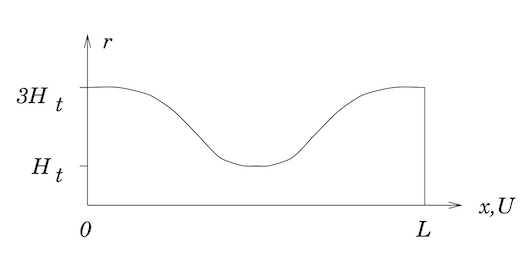

The duct is defined by:
$$
    r=2H_t + H_t cos \left( 2\pi \frac{x}{L} \right)
$$

where $L=1$ [m], $H_t=0.01$ [m].  You will have to modify the `Grid` class in order to solve this problem. Keep the general structure of the class, but modify the calculation of the areas and volumes appropriately. The inlet velocity should be imposed as $u=2$ [m/s].  To eliminate friction in the duct, be sure to turn off the wall friction terms from the previous problem.  Solve the problem using 8, 16, 32 and 64 equal-length control-volumes and calculate the loss in dynamic head from each converged solution.  The dynamic head loss is given as:

$$
    C_D= \frac{P_{in} - P_{out}}{\frac{1}{2} \rho U_{in}^2}
$$

Compare your solutions from UDS with those from the second-order schemes and quantify the convergence characteristics of each.  Plot the velocities and pressures versus $x$ for enough of the cases to visualize the results properly.  What should $C_D$ become for this problem?

# Class definition

In [299]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, Ht, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            Ht .... total length of domain in y-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate the radius of the channel at face locations
        self._rf = (2*Ht) + (Ht*np.cos((2*np.pi*self._xf)/lx))
        
        # Calculate the radius of the channel at cell centroid locations
        self._rP = (2*Ht) + (Ht*np.cos((2*np.pi*self._xP)/lx))
        
        # Calculate face areas
        self._Af = np.pi * ((self._rf)**2)

        # Calculate the outer surface area for each cell
        self._Ao = (2*np.pi*self._rP[1:-1])*dx

        # Calculate cell volumes
        self._vol = np.pi*(self._rP[1:-1]**2)*dx
        #self._vol = self._Ao*dx
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def rf(self):
        """Radius at Face location array"""
        return self._rf
    
    @property
    def rP(self):
        """Radius at Cell centroid array"""
        return self._rP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [300]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [301]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [302]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

import numpy

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, phi, phiold, rho, const, dt):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._phiold = phiold
        self._rho = rho
        self._const = const
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._const*self._grid.vol*(self._phi[1:-1]-self._phiold[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._const*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [303]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""

    # Get number of control volumes (check that all are consistent)
    ncv = PP_coeffs.ncv
    if ncv is not PU_coeffs.ncv or ncv is not UP_coeffs.ncv or ncv is not UU_coeffs.ncv:
        raise ValueError("Not all coefficient arrays have the same dimension")

    # Set up the data and indexing arrays
    nvar = 2  # P, U
    ncoeff = 3  # aW, aP, and aE
    ndata = nvar*nvar*ncoeff*ncv - 2*nvar*nvar # Need to subtract boundary coefficients
    data = np.zeros(ndata)
    rows = np.zeros(ndata, dtype=int)
    cols = np.zeros(ndata, dtype=int)

    # Set up the first cell
    data[0] = PP_coeffs.aP[0]
    cols[0] = 0
    data[1] = PU_coeffs.aP[0]
    cols[1] = 1
    data[2] = PP_coeffs.aE[0]
    cols[2] = 2
    data[3] = PU_coeffs.aE[0]
    cols[3] = 3
    data[4] = UP_coeffs.aP[0]
    cols[4] = 0
    data[5] = UU_coeffs.aP[0]
    cols[5] = 1
    data[6] = UP_coeffs.aE[0]
    cols[6] = 2
    data[7] = UU_coeffs.aE[0]
    cols[7] = 3

    rows[0:4] = 0
    rows[4:8] = 1

    # Set up the interior cells
    for i in range(1, ncv-1):
        start = nvar*nvar*ncoeff*(i-1) + 8
        data[start+0] = PP_coeffs.aW[i]
        cols[start+0] = nvar*i - 2
        data[start+1] = PU_coeffs.aW[i]
        cols[start+1] = nvar*i - 1
        data[start+2] = PP_coeffs.aP[i]
        cols[start+2] = nvar*i
        data[start+3] = PU_coeffs.aP[i]
        cols[start+3] = nvar*i + 1
        data[start+4] = PP_coeffs.aE[i]
        cols[start+4] = nvar*i + 2
        data[start+5] = PU_coeffs.aE[i]
        cols[start+5] = nvar*i + 3
        data[start+6] = UP_coeffs.aW[i]
        cols[start+6] = nvar*i - 2
        data[start+7] = UU_coeffs.aW[i]
        cols[start+7] = nvar*i - 1
        data[start+8] = UP_coeffs.aP[i]
        cols[start+8] = nvar*i
        data[start+9] = UU_coeffs.aP[i]
        cols[start+9] = nvar*i + 1
        data[start+10] = UP_coeffs.aE[i]
        cols[start+10] = nvar*i + 2
        data[start+11] = UU_coeffs.aE[i]
        cols[start+11] = nvar*i + 3

        rows[start:start+6] = nvar*i
        rows[start+6:start+12] = nvar*i + 1

    # Set up the last cell
    i = ncv - 1
    start = nvar*nvar*ncoeff*(i-1) + 8
    data[start+0] = PP_coeffs.aW[i]
    cols[start+0] = nvar*i - 2
    data[start+1] = PU_coeffs.aW[i]
    cols[start+1] = nvar*i - 1
    data[start+2] = PP_coeffs.aP[i]
    cols[start+2] = nvar*i
    data[start+3] = PU_coeffs.aP[i]
    cols[start+3] = nvar*i + 1
    data[start+4] = UP_coeffs.aW[i]
    cols[start+4] = nvar*i - 2
    data[start+5] = UU_coeffs.aW[i]
    cols[start+5] = nvar*i - 1
    data[start+6] = UP_coeffs.aP[i]
    cols[start+6] = nvar*i
    data[start+7] = UU_coeffs.aP[i]
    cols[start+7] = nvar*i + 1

    rows[start:start+4] = nvar*i
    rows[start+4:start+8] = nvar*i + 1

    # Return the matrix
    return csr_matrix((data, (rows, cols)))

def solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs):
    """Function to solve the linear system and return the correction fields"""

    # Get number of control volumes (check that all are consistent)
    ncv = PP_coeffs.ncv
    if ncv is not PU_coeffs.ncv or ncv is not UP_coeffs.ncv or ncv is not UU_coeffs.ncv:
        raise ValueError("Not all coefficient arrays have the same dimension")

    # Get the sparse matrix
    A = get_sparse_matrix(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

    # Create and fill the right side vector
    b = np.zeros(2*ncv)
    for i in range(ncv):
        b[2*i] = - PP_coeffs.rP[i] - PU_coeffs.rP[i]
        b[2*i+1] = - UP_coeffs.rP[i] - UU_coeffs.rP[i]

    # Solve the linear system
    res = spsolve(A,b)

    # Extract the correction fields
    dP = np.zeros(ncv)
    dU = np.zeros(ncv)
    for i in range(ncv):
        dP[i] = res[2*i]
        dU[i] = res[2*i+1]

    return dP, dU


In [304]:
class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1           
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [305]:
class CentralDifferenceModel:
    """Class defining a Central difference advection model with Deffered correction approach"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
 
    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                #self._alphae [-1] = -1
            else:
                self._alphae[i] = -1
                #self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (self._phi[0:-1] + self._phi[1:])/2 # Using HOS
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:] # For modification of boundary values
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face      
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
                
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)
 
        # Return the modified coefficient array
        return coeffs

In [306]:
import numpy as np

class QuickAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
                #self._alphae[-1] = -1
            else:
                self._alphae[i] = -1
                #self._alphae[0] = 1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1- self._alphae)/2*self._phi[1:]
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        for i in range(1,self._grid.ncv):
                if self._Uhe[i] >=0:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i] - self._grid.xP[i-1])*(self._grid.xP[i] - self._grid.xP[i+1])))*self._phi[i]  
                    T_3 = ((self._grid.xf[i] - self._grid.xP[i-1])*(self._grid.xf[i] - self._grid.xP[i])/((self._grid.xP[i+1] - self._grid.xP[i-1])*(self._grid.xP[i+1] - self._grid.xP[i])))*self._phi[i+1]
                    self._phie[i] = T_1 + T_2 + T_3
        
                else:
                    T_1 = ((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i] - self._grid.xP[i+1])*(self._grid.xP[i] - self._grid.xP[i+2])))*self._phi[i]  
                    T_2 = ((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+2])/((self._grid.xP[i+1] - self._grid.xP[i])*(self._grid.xP[i+1] - self._grid.xP[i+2])))*self._phi[i+1]  
                    T_3 =((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1])/((self._grid.xP[i+2] - self._grid.xP[i])*(self._grid.xP[i+2] - self._grid.xP[i+1])))*self._phi[i+2]                
                    self._phie[i] = T_1 + T_2 + T_3
   
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs


In [307]:
class AdvectingVelocityModel:
    """Class defining an advecting velocity model"""

    def __init__(self, grid, dhat, Uhe, P, U, coeffs):
        """Constructor"""
        self._grid = grid
        self._dhat = dhat
        self._Uhe = Uhe
        self._P = P
        self._U = U
        self._coeffs = coeffs

    def update(self):
        """Function to update the advecting velocity array"""

        # Calculate the pressure gradients across the faces
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        
        # Calculate the cell pressure gradients
        gradP = 0.5*(gradPw + gradPe)
          
        # Calculate damping coefficient, dhat
        Ve = 0.5*(self._grid.vol[0:-1] + self._grid.vol[1:])
        ae = 0.5*(self._coeffs.aP[0:-1] + self._coeffs.aP[1:])
        self._dhat[1:-1] = Ve/ae

        # Update the advecting velocity
        self._Uhe[0] = self._U[0]
        self._Uhe[1:-1] = 0.5*(self._U[1:-2] + self._U[2:-1]) - self._dhat[1:-1]*(gradPe[:-1] - 0.5*(gradP[:-1] + gradP[1:]))
        self._Uhe[-1] = self._U[-1]

In [308]:
class PressureForceModel:
    """Class defining a pressure force model"""

    def __init__(self, grid, P, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._P = P
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the pressure force
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        force = 0.5*(gradPw + gradPe)*self._grid.vol
          
        # Calculate the linearization coefficients
        coeffW = - 0.5*self._grid.vol/self._grid.dx_WP
        coeffE = 0.5*self._grid.vol/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(force)

        # Return the modified coefficient array
        return coeffs

In [309]:
class MassConservationEquation:
    """Class defining a mass conservation equation"""

    def __init__(self, grid, U, P, dhat, Uhe, rho, 
                 P_west_bc, P_east_bc, U_west_bc, U_east_bc):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._P = P
        self._dhat = dhat
        self._Uhe = Uhe
        self._rho = rho
        self._P_west_bc = P_west_bc
        self._P_east_bc = P_east_bc
        self._U_west_bc = U_west_bc
        self._U_east_bc = U_east_bc

    def add(self, PP_coeffs, PU_coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the mass imbalance, based on advecting velocities
        imbalance = self._rho*self._grid.Ae*self._Uhe[1:] - self._rho*self._grid.Aw*self._Uhe[:-1]
              
        # Calculate the linearization coefficients on pressure
        PP_coeffW = np.concatenate((np.array([0]), -self._rho*self._grid.Aw[1:]*self._dhat[1:-1]/self._grid.dx_WP[1:]))
        PP_coeffE = np.concatenate((-self._rho*self._grid.Ae[:-1]*self._dhat[1:-1]/self._grid.dx_PE[:-1], np.array([0])))
        PP_coeffP = - PP_coeffW - PP_coeffE
        
        # Calculate the linearization coefficients on velocity
        PU_coeffW = np.concatenate((np.array([-self._rho*self._grid.Aw[0]]), -0.5*self._rho*self._grid.Aw[1:]))
        PU_coeffE = np.concatenate((0.5*self._rho*self._grid.Ae[:-1], np.array([self._rho*self._grid.Ae[-1]])))
        PU_coeffP = np.concatenate((np.array([0]), PU_coeffW[1:])) + np.concatenate((PU_coeffE[:-1], np.array([0])))

        # Modify the linearization coefficients on the boundaries 
        # (velocity only, since pressure is already zero)
        PU_coeffP[0] += PU_coeffW[0]*self._U_west_bc.coeff()
        PU_coeffP[-1] += PU_coeffE[-1]*self._U_east_bc.coeff()

        # Zero the boundary coefficients that are not used
        PU_coeffW[0] = 0.0
        PU_coeffE[-1] = 0.0

        # Add to coefficient arrays
        PP_coeffs.accumulate_aP(PP_coeffP)
        PP_coeffs.accumulate_aW(PP_coeffW)
        PP_coeffs.accumulate_aE(PP_coeffE)
        PP_coeffs.accumulate_rP(imbalance)
        PU_coeffs.accumulate_aP(PU_coeffP)
        PU_coeffs.accumulate_aW(PU_coeffW)
        PU_coeffs.accumulate_aE(PU_coeffE)

        # Return the modified coefficient arrays
        return PP_coeffs, PU_coeffs

In [310]:
class ExtrapolatedBc:
    """Class defining an extrapolated boundary condition"""

    def __init__(self, phi, grid, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - ((self._grid.dx_WP[0] / self._grid.dx_PE[0]) * (self._phi[2]-self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + ((self._grid.dx_PE[-1] / self._grid.dx_WP[-1]) * (self._phi[-2]-self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1 + (self._grid.dx_WP[0] / self._grid.dx_PE[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (1 + (self._grid.dx_PE[-1] / self._grid.dx_WP[-1]))
        else:
            raise ValueError("Unknown boundary location")

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            pass 
            self._phi[0] = self._phi[1] - ((self._grid.dx_WP[0] / self._grid.dx_PE[0]) * (self._phi[2]-self._phi[1]))
        elif self._loc is BoundaryLocation.EAST:
            pass 
            self._phi[-1] = self._phi[-2] + ((self._grid.dx_PE[-1] / self._grid.dx_WP[-1]) * (self._phi[-2]-self._phi[-3]))
        else:
            raise ValueError("Unknown boundary location")

# Solving the problem with UDS 

In [322]:
def UDS (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = Grid(lx, Ht, ncv)

    # Set the timestep information
    nTime = 100
    dt = 0.1
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 20
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU
            #P[1:-1] = 0.7*P[1:-1] + 0.3*(P[1:-1]+dP)
            #U[1:-1] = 0.7*U[1:-1] + 0.3*(U[1:-1]+dU)

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_uds = U
    P_uds = P
    loc_uds = grid.xP
    return (U_uds,P_uds,loc_uds)

In [323]:
print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_uds_8, P_uds_8, loc_uds_8 = UDS(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_uds_16, P_uds_16, loc_uds_16 = UDS(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_uds_32, P_uds_32, loc_uds_32 = UDS(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_uds_64, P_uds_64, loc_uds_64 = UDS(64)

                                      Results for ncv = 8                                       
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 4.5465365730854135; Avg. Resid. = 2.001991990726721
  Momentum: Max. Resid. = 54.81724544732077; Avg. Resid. = 14.736034029438716
Iteration = 2.
  Mass:     Max. Resid. = 3.9273766097123586; Avg. Resid. = 2.1069122179106303
  Momentum: Max. Resid. = 74.66964622680035; Avg. Resid. = 12.344793034023272
Iteration = 3.
  Mass:     Max. Resid. = 3.7923058894031874; Avg. Resid. = 1.6181899042455377
  Momentum: Max. Resid. = 33.573328683727205; Avg. Resid. = 6.929457929075586
Iteration = 4.
  Mass:     Max. Resid. = 4.9877947417032455; Avg. Resid. = 1.550594296501171
  Momentum: Max. Resid. = 4.840598447519312; Avg. Resid. = 2.8055797624287484
Iteration = 5.
  Mass:     Max. Resid. = 1.900792

Iteration = 10.
  Mass:     Max. Resid. = 5.667277246601543e-06; Avg. Resid. = 1.9040529910530068e-06
  Momentum: Max. Resid. = 2.173511046010823e-05; Avg. Resid. = 6.616979512846788e-06
Iteration = 11.
  Mass:     Max. Resid. = 2.2661595284745317e-06; Avg. Resid. = 6.566106525163207e-07
  Momentum: Max. Resid. = 2.4539786442234757e-05; Avg. Resid. = 4.9195292376458255e-06
Iteration = 12.
  Mass:     Max. Resid. = 2.462891398380407e-06; Avg. Resid. = 6.957005782570747e-07
  Momentum: Max. Resid. = 7.489759461298817e-06; Avg. Resid. = 2.6744990861068962e-06
Iteration = 13.
  Mass:     Max. Resid. = 1.2345037543326498e-06; Avg. Resid. = 4.210744888322182e-07
  Momentum: Max. Resid. = 1.2386559993249335e-05; Avg. Resid. = 2.408372959776528e-06
Iteration = 14.
  Mass:     Max. Resid. = 8.349251627848275e-07; Avg. Resid. = 2.7219819864754413e-07
  Momentum: Max. Resid. = 2.5681937696475643e-06; Avg. Resid. = 7.829126848074575e-07
Iteration = 15.
  Mass:     Max. Resid. = 6.049408476371809e-

Iteration = 0.
  Mass:     Max. Resid. = 2.782983079541168e-07; Avg. Resid. = 9.966668046423877e-08
  Momentum: Max. Resid. = 7.455534571931821e-07; Avg. Resid. = 2.0299166254150736e-07
Timestep = 36; Time = 3.700000000000002
Iteration = 0.
  Mass:     Max. Resid. = 2.7829830884229523e-07; Avg. Resid. = 9.966668068628337e-08
  Momentum: Max. Resid. = 7.455534500877548e-07; Avg. Resid. = 2.0299166165332894e-07
Timestep = 37; Time = 3.800000000000002
Iteration = 0.
  Mass:     Max. Resid. = 2.782983079541168e-07; Avg. Resid. = 9.966668046423877e-08
  Momentum: Max. Resid. = 7.455534571931821e-07; Avg. Resid. = 2.0299166254150736e-07
Timestep = 38; Time = 3.900000000000002
Iteration = 0.
  Mass:     Max. Resid. = 2.7829830884229523e-07; Avg. Resid. = 9.966668068628337e-08
  Momentum: Max. Resid. = 7.455534500877548e-07; Avg. Resid. = 2.0299166165332894e-07
Timestep = 39; Time = 4.000000000000002
Iteration = 0.
  Mass:     Max. Resid. = 2.782983079541168e-07; Avg. Resid. = 9.96666804642387

Iteration = 14.
  Mass:     Max. Resid. = 0.05574948416819403; Avg. Resid. = 0.008187166065207974
  Momentum: Max. Resid. = 0.30923525984433886; Avg. Resid. = 0.026998608135118667
Iteration = 15.
  Mass:     Max. Resid. = 0.03467661403487199; Avg. Resid. = 0.0047610336882295545
  Momentum: Max. Resid. = 0.12172655028594637; Avg. Resid. = 0.014802204132005496
Iteration = 16.
  Mass:     Max. Resid. = 0.0033997830500327453; Avg. Resid. = 0.0008461736759440841
  Momentum: Max. Resid. = 0.02654668216994338; Avg. Resid. = 0.0062947326272568965
Iteration = 17.
  Mass:     Max. Resid. = 0.012825685449124435; Avg. Resid. = 0.0018179610170412364
  Momentum: Max. Resid. = 0.07796128550961312; Avg. Resid. = 0.00689438510855301
Iteration = 18.
  Mass:     Max. Resid. = 0.009793296698847875; Avg. Resid. = 0.001276758986428761
  Momentum: Max. Resid. = 0.03538610778808993; Avg. Resid. = 0.004040372501475022
Iteration = 19.
  Mass:     Max. Resid. = 0.0012100119671423215; Avg. Resid. = 0.000227690610

Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.1143162210488526e-08
  Momentum: Max. Resid. = 4.510228694409868e-07; Avg. Resid. = 7.922982218563912e-08
Timestep = 45; Time = 4.6
Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.114316232151083e-08
  Momentum: Max. Resid. = 4.510228694409868e-07; Avg. Resid. = 7.922982218563912e-08
Timestep = 46; Time = 4.699999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.1143162210488526e-08
  Momentum: Max. Resid. = 4.510228694409868e-07; Avg. Resid. = 7.922982218563912e-08
Timestep = 47; Time = 4.799999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.114316232151083e-08
  Momentum: Max. Resid. = 4.510228694409868e-07; Avg. Resid. = 7.922982218563912e-08
Timestep = 48; Time = 4.899999999999999
Iteration = 0.
  Mass:     Max. Resid. = 2.261315383833562e-07; Avg. Resid. = 4.1143162210488526e-08
  Momentum:

Iteration = 13.
  Mass:     Max. Resid. = 0.0025181795638040683; Avg. Resid. = 0.0008056636873826073
  Momentum: Max. Resid. = 0.0025520091731960903; Avg. Resid. = 0.0008099232689212183
Iteration = 14.
  Mass:     Max. Resid. = 0.0011990591090764724; Avg. Resid. = 0.0003398601455099626
  Momentum: Max. Resid. = 0.004648307120970641; Avg. Resid. = 0.0005516528838884135
Iteration = 15.
  Mass:     Max. Resid. = 0.0008604364343192117; Avg. Resid. = 0.00015815933796087256
  Momentum: Max. Resid. = 0.0021388629691873745; Avg. Resid. = 0.00023230188677212738
Iteration = 16.
  Mass:     Max. Resid. = 0.0009976158959457138; Avg. Resid. = 0.00014064035537519892
  Momentum: Max. Resid. = 0.003633818261885177; Avg. Resid. = 0.00019131874914174755
Iteration = 17.
  Mass:     Max. Resid. = 0.0003682323391602793; Avg. Resid. = 6.155167298776965e-05
  Momentum: Max. Resid. = 0.0011525832349200127; Avg. Resid. = 8.187967863711697e-05
Iteration = 18.
  Mass:     Max. Resid. = 0.00011667686807026456; Av

  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 92; Time = 9.299999999999983
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 93; Time = 9.399999999999983
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 94; Time = 9.499999999999982
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum: Max. Resid. = 9.757319477526893e-07; Avg. Resid. = 5.201810159395984e-08
Timestep = 95; Time = 9.599999999999982
Iteration = 0.
  Mass:     Max. Resid. = 2.538770456084194e-07; Avg. Resid. = 3.8069978447463626e-08
  Momentum

Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 13; Time = 1.4000000000000001
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 14; Time = 1.5000000000000002
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 15; Time = 1.6000000000000003
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.3146347732639896e-08
  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09
Timestep = 16; Time = 1.7000000000000004
Iteration = 0.
  Mass:     Max. Resid. = 1.2787814096526517e-07; Avg. Resid. = 1.31463477326

  Momentum: Max. Resid. = 2.576944811462367e-07; Avg. Resid. = 8.45015237660061e-09


# Solving the problem with CDS

In [326]:
def CDS (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = Grid(lx, Ht, ncv)

    # Set the timestep information
    nTime = 100
    dt = 0.1
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 20
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = CentralDifferenceModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU
            #P[1:-1] = 0.95*P[1:-1] + 0.05*(P[1:-1]+dP)
            #U[1:-1] = 0.95*U[1:-1] + 0.05*(U[1:-1]+dU)

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_cds = U
    P_cds = P
    loc_cds = grid.xP
    return (U_cds,P_cds,loc_cds)

In [327]:
print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_cds_8, P_cds_8, loc_cds_8 = CDS(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_cds_16, P_cds_16, loc_cds_16 = CDS(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_cds_32, P_cds_32, loc_cds_32 = CDS(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_cds_64, P_cds_64, loc_cds_64 = CDS(64)

                                      Results for ncv = 8                                       
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 4.5465365730854135; Avg. Resid. = 2.001991990726721
  Momentum: Max. Resid. = 44.784460682888806; Avg. Resid. = 11.766850560816259
Iteration = 2.
  Mass:     Max. Resid. = 3.5458226805858173; Avg. Resid. = 1.63543382639173
  Momentum: Max. Resid. = 59.32710355009229; Avg. Resid. = 13.37843173142363
Iteration = 3.
  Mass:     Max. Resid. = 6.572683325235806; Avg. Resid. = 2.5121021096829375
  Momentum: Max. Resid. = 10.829193688591054; Avg. Resid. = 6.5385844114060365
Iteration = 4.
  Mass:     Max. Resid. = 6.39889143727197; Avg. Resid. = 2.1995064737845036
  Momentum: Max. Resid. = 63.88549820719407; Avg. Resid. = 13.927834695858328
Iteration = 5.
  Mass:     Max. Resid. = 2.036832776

Iteration = 8.
  Mass:     Max. Resid. = 1.0991547931048187; Avg. Resid. = 0.3850454421050532
  Momentum: Max. Resid. = 27.827759604750117; Avg. Resid. = 7.905187842694374
Iteration = 9.
  Mass:     Max. Resid. = 1.6090099200679822; Avg. Resid. = 0.5309144304952661
  Momentum: Max. Resid. = 44.218096694706134; Avg. Resid. = 10.492749557100451
Iteration = 10.
  Mass:     Max. Resid. = 1.5023744700547939; Avg. Resid. = 0.4700211222141666
  Momentum: Max. Resid. = 33.52752049589135; Avg. Resid. = 9.406511535007407
Iteration = 11.
  Mass:     Max. Resid. = 1.8355980101660156; Avg. Resid. = 0.5982347271836748
  Momentum: Max. Resid. = 55.24225965650385; Avg. Resid. = 12.851917354151167
Iteration = 12.
  Mass:     Max. Resid. = 1.9125868449295105; Avg. Resid. = 0.6406730386887073
  Momentum: Max. Resid. = 38.34842040183262; Avg. Resid. = 11.081645073527525
Iteration = 13.
  Mass:     Max. Resid. = 2.2664756382452413; Avg. Resid. = 0.7061625937088397
  Momentum: Max. Resid. = 67.5772238173549

Iteration = 3.
  Mass:     Max. Resid. = 2.218050836194747; Avg. Resid. = 0.6916971218319207
  Momentum: Max. Resid. = 70.22010397636653; Avg. Resid. = 14.978338976435591
Iteration = 4.
  Mass:     Max. Resid. = 1.8375054297965647; Avg. Resid. = 0.9277202562744018
  Momentum: Max. Resid. = 34.403639390504644; Avg. Resid. = 10.941716761144951
Iteration = 5.
  Mass:     Max. Resid. = 2.2113094426952014; Avg. Resid. = 0.6842379603910022
  Momentum: Max. Resid. = 67.1333564046531; Avg. Resid. = 14.405007735275829
Iteration = 6.
  Mass:     Max. Resid. = 1.7585407978287977; Avg. Resid. = 0.8740474384193994
  Momentum: Max. Resid. = 34.01498914169234; Avg. Resid. = 10.626226731136303
Iteration = 7.
  Mass:     Max. Resid. = 2.106998201823216; Avg. Resid. = 0.6544283022296568
  Momentum: Max. Resid. = 64.91912815075304; Avg. Resid. = 14.029603283029815
Iteration = 8.
  Mass:     Max. Resid. = 1.7550723765870746; Avg. Resid. = 0.8507657769148826
  Momentum: Max. Resid. = 33.72075168024894; Avg

Iteration = 4.
  Mass:     Max. Resid. = 1.7946301384446972; Avg. Resid. = 0.8306136669321724
  Momentum: Max. Resid. = 34.92345774285064; Avg. Resid. = 10.647883986460581
Iteration = 5.
  Mass:     Max. Resid. = 2.120061639621463; Avg. Resid. = 0.6567588354169948
  Momentum: Max. Resid. = 65.64821170468115; Avg. Resid. = 14.234360608377495
Iteration = 6.
  Mass:     Max. Resid. = 1.8095939207798075; Avg. Resid. = 0.8420422826354127
  Momentum: Max. Resid. = 35.03518109002017; Avg. Resid. = 10.724126941215236
Iteration = 7.
  Mass:     Max. Resid. = 2.149373689587372; Avg. Resid. = 0.6651070266967247
  Momentum: Max. Resid. = 66.2138265019055; Avg. Resid. = 14.331304843770248
Iteration = 8.
  Mass:     Max. Resid. = 1.8117992256812174; Avg. Resid. = 0.8473717398195418
  Momentum: Max. Resid. = 35.14135163537162; Avg. Resid. = 10.778941474812004
Iteration = 9.
  Mass:     Max. Resid. = 2.1674021178713376; Avg. Resid. = 0.6729760230743284
  Momentum: Max. Resid. = 66.75010852923496; Avg.

Iteration = 3.
  Mass:     Max. Resid. = 2.1524758307030067; Avg. Resid. = 0.6678147543462887
  Momentum: Max. Resid. = 66.51090187932036; Avg. Resid. = 14.362641710778501
Iteration = 4.
  Mass:     Max. Resid. = 1.8099202236422567; Avg. Resid. = 0.8571361189032461
  Momentum: Max. Resid. = 34.88774016541502; Avg. Resid. = 10.74201390870161
Iteration = 5.
  Mass:     Max. Resid. = 2.152526169989894; Avg. Resid. = 0.6675427118820175
  Momentum: Max. Resid. = 66.32658170942547; Avg. Resid. = 14.32834144006335
Iteration = 6.
  Mass:     Max. Resid. = 1.8055296038463373; Avg. Resid. = 0.8540235988799435
  Momentum: Max. Resid. = 34.8598996290267; Avg. Resid. = 10.722253595403181
Iteration = 7.
  Mass:     Max. Resid. = 2.145331520027331; Avg. Resid. = 0.6654810174637174
  Momentum: Max. Resid. = 66.18193548382882; Avg. Resid. = 14.303703616184858
Iteration = 8.
  Mass:     Max. Resid. = 1.805103658159804; Avg. Resid. = 0.8526151007586834
  Momentum: Max. Resid. = 34.83542823294431; Avg. Re

Iteration = 18.
  Mass:     Max. Resid. = 1.8032684859348302; Avg. Resid. = 0.8500127821057389
  Momentum: Max. Resid. = 34.858708037416584; Avg. Resid. = 10.70712130083416
Iteration = 19.
  Mass:     Max. Resid. = 2.1418596919703257; Avg. Resid. = 0.6638742269099654
  Momentum: Max. Resid. = 66.05390790808603; Avg. Resid. = 14.28244526413598
Timestep = 15; Time = 1.6000000000000003
Iteration = 0.
  Mass:     Max. Resid. = 1.8033260095328862; Avg. Resid. = 0.8498989923394031
  Momentum: Max. Resid. = 34.86047158626984; Avg. Resid. = 10.712669056913475
Iteration = 1.
  Mass:     Max. Resid. = 2.1434123448526865; Avg. Resid. = 0.6646927568136834
  Momentum: Max. Resid. = 66.08427620254096; Avg. Resid. = 14.287208070696657
Iteration = 2.
  Mass:     Max. Resid. = 1.8030139362196067; Avg. Resid. = 0.8494716016186024
  Momentum: Max. Resid. = 34.886975958836715; Avg. Resid. = 10.714385473005937
Iteration = 3.
  Mass:     Max. Resid. = 2.145031127180679; Avg. Resid. = 0.665029688624518
  Mom

Iteration = 15.
  Mass:     Max. Resid. = 2.147762960568479; Avg. Resid. = 0.6660232374302417
  Momentum: Max. Resid. = 66.2439418546197; Avg. Resid. = 14.319894495314777
Iteration = 16.
  Mass:     Max. Resid. = 1.8078377685666895; Avg. Resid. = 0.8522668126909584
  Momentum: Max. Resid. = 34.91178632370037; Avg. Resid. = 10.728694105942004
Iteration = 17.
  Mass:     Max. Resid. = 2.1477957543835338; Avg. Resid. = 0.6660542977340523
  Momentum: Max. Resid. = 66.2462873197471; Avg. Resid. = 14.320394512467951
Iteration = 18.
  Mass:     Max. Resid. = 1.8079469615339643; Avg. Resid. = 0.8523114801249383
  Momentum: Max. Resid. = 34.912138129964376; Avg. Resid. = 10.728823809915474
Iteration = 19.
  Mass:     Max. Resid. = 2.1477750575156067; Avg. Resid. = 0.6660476329154633
  Momentum: Max. Resid. = 66.24736513113297; Avg. Resid. = 14.32057828974366
Timestep = 18; Time = 1.9000000000000006
Iteration = 0.
  Mass:     Max. Resid. = 1.8079317318841177; Avg. Resid. = 0.8523405421903754
  M

Timestep = 21; Time = 2.2000000000000006
Iteration = 0.
  Mass:     Max. Resid. = 1.8067595715682674; Avg. Resid. = 0.8517190198144554
  Momentum: Max. Resid. = 34.898664747927775; Avg. Resid. = 10.723657341705227
Iteration = 1.
  Mass:     Max. Resid. = 2.146369318020052; Avg. Resid. = 0.6655470166030304
  Momentum: Max. Resid. = 66.20008923146204; Avg. Resid. = 14.311178018507865
Iteration = 2.
  Mass:     Max. Resid. = 1.8067397815900992; Avg. Resid. = 0.8516914279323102
  Momentum: Max. Resid. = 34.900384490269644; Avg. Resid. = 10.723770577502211
Iteration = 3.
  Mass:     Max. Resid. = 2.146475136455434; Avg. Resid. = 0.6655691337067302
  Momentum: Max. Resid. = 66.20305878451117; Avg. Resid. = 14.312006249383039
Iteration = 4.
  Mass:     Max. Resid. = 1.8069482705908406; Avg. Resid. = 0.8517574358419524
  Momentum: Max. Resid. = 34.90150490313943; Avg. Resid. = 10.724122829909156
Iteration = 5.
  Mass:     Max. Resid. = 2.146473973615735; Avg. Resid. = 0.6655733662920789
  Mome

Iteration = 4.
  Mass:     Max. Resid. = 1.8070099545751974; Avg. Resid. = 0.8518674655512828
  Momentum: Max. Resid. = 34.9012566298999; Avg. Resid. = 10.724494996572279
Iteration = 5.
  Mass:     Max. Resid. = 2.146600295611151; Avg. Resid. = 0.665614716139373
  Momentum: Max. Resid. = 66.20862724477139; Avg. Resid. = 14.312907234967975
Iteration = 6.
  Mass:     Max. Resid. = 1.8069919170106759; Avg. Resid. = 0.8518545479278626
  Momentum: Max. Resid. = 34.90113906190411; Avg. Resid. = 10.724412250543482
Iteration = 7.
  Mass:     Max. Resid. = 2.146569895329031; Avg. Resid. = 0.6656060094967052
  Momentum: Max. Resid. = 66.20802000644997; Avg. Resid. = 14.312803673767869
Iteration = 8.
  Mass:     Max. Resid. = 1.8069900132430181; Avg. Resid. = 0.8518486697744596
  Momentum: Max. Resid. = 34.901034199402964; Avg. Resid. = 10.724354740838816
Iteration = 9.
  Mass:     Max. Resid. = 2.1465504863265297; Avg. Resid. = 0.6655977606907403
  Momentum: Max. Resid. = 66.20746482840215; Avg.

Iteration = 1.
  Mass:     Max. Resid. = 2.1465693259947356; Avg. Resid. = 0.6656047853558636
  Momentum: Max. Resid. = 66.20790120542318; Avg. Resid. = 14.312795219080336
Iteration = 2.
  Mass:     Max. Resid. = 1.8069907358521888; Avg. Resid. = 0.8518411389833768
  Momentum: Max. Resid. = 34.90128311059231; Avg. Resid. = 10.724402614151648
Iteration = 3.
  Mass:     Max. Resid. = 2.146572082170911; Avg. Resid. = 0.6656053615805997
  Momentum: Max. Resid. = 66.20797852514849; Avg. Resid. = 14.312816783291167
Iteration = 4.
  Mass:     Max. Resid. = 1.8069961630557407; Avg. Resid. = 0.8518428573495304
  Momentum: Max. Resid. = 34.90131227797211; Avg. Resid. = 10.724411784605207
Iteration = 5.
  Mass:     Max. Resid. = 2.146572052029999; Avg. Resid. = 0.6656054718677812
  Momentum: Max. Resid. = 66.20805709677451; Avg. Resid. = 14.312831406757214
Iteration = 6.
  Mass:     Max. Resid. = 1.8069980073951561; Avg. Resid. = 0.8518441782173634
  Momentum: Max. Resid. = 34.901324300628595; Av

Iteration = 15.
  Mass:     Max. Resid. = 2.146576677491634; Avg. Resid. = 0.6656070329357124
  Momentum: Max. Resid. = 66.2081704619185; Avg. Resid. = 14.31285034818885
Iteration = 16.
  Mass:     Max. Resid. = 1.8069988604487568; Avg. Resid. = 0.851845851963153
  Momentum: Max. Resid. = 34.90132480161662; Avg. Resid. = 10.724426717000494
Iteration = 17.
  Mass:     Max. Resid. = 2.1465767326672704; Avg. Resid. = 0.6656070852500869
  Momentum: Max. Resid. = 66.20817441152218; Avg. Resid. = 14.312851190452418
Iteration = 18.
  Mass:     Max. Resid. = 1.8069990445658162; Avg. Resid. = 0.8518459271800097
  Momentum: Max. Resid. = 34.901325396603234; Avg. Resid. = 10.724426935679086
Iteration = 19.
  Mass:     Max. Resid. = 2.1465766977125016; Avg. Resid. = 0.6656070740098576
  Momentum: Max. Resid. = 66.20817622890307; Avg. Resid. = 14.312851500665582
Timestep = 32; Time = 3.3000000000000016
Iteration = 0.
  Mass:     Max. Resid. = 1.8069990190634844; Avg. Resid. = 0.8518459761794133
  M

Iteration = 5.
  Mass:     Max. Resid. = 2.146574940454598; Avg. Resid. = 0.6656064172879455
  Momentum: Max. Resid. = 66.20811540839645; Avg. Resid. = 14.31283916258161
Iteration = 6.
  Mass:     Max. Resid. = 1.80699738489401; Avg. Resid. = 0.8518452387268394
  Momentum: Max. Resid. = 34.90130536117551; Avg. Resid. = 10.724419429275757
Iteration = 7.
  Mass:     Max. Resid. = 2.146574622560122; Avg. Resid. = 0.665606326243005
  Momentum: Max. Resid. = 66.20810905865761; Avg. Resid. = 14.31283807966219
Iteration = 8.
  Mass:     Max. Resid. = 1.8069973649819304; Avg. Resid. = 0.8518451772618947
  Momentum: Max. Resid. = 34.901304264563386; Avg. Resid. = 10.724418827896713
Iteration = 9.
  Mass:     Max. Resid. = 2.146574419603591; Avg. Resid. = 0.6656062399850806
  Momentum: Max. Resid. = 66.20810325309775; Avg. Resid. = 14.31283692952145
Iteration = 10.
  Mass:     Max. Resid. = 1.8069971673857244; Avg. Resid. = 0.8518450939931553
  Momentum: Max. Resid. = 34.901302921114606; Avg. Re

Iteration = 16.
  Mass:     Max. Resid. = 1.8069972976651902; Avg. Resid. = 0.8518450675735563
  Momentum: Max. Resid. = 34.9013053099736; Avg. Resid. = 10.724418767568814
Iteration = 17.
  Mass:     Max. Resid. = 2.1465744618232314; Avg. Resid. = 0.6656062523073535
  Momentum: Max. Resid. = 66.20810341207897; Avg. Resid. = 14.31283713955193
Iteration = 18.
  Mass:     Max. Resid. = 1.8069972788377102; Avg. Resid. = 0.8518450598820299
  Momentum: Max. Resid. = 34.90130524913112; Avg. Resid. = 10.724418745207151
Iteration = 19.
  Mass:     Max. Resid. = 2.1465744653976593; Avg. Resid. = 0.665606253456754
  Momentum: Max. Resid. = 66.20810322623686; Avg. Resid. = 14.31283710783004
Timestep = 37; Time = 3.800000000000002
Iteration = 0.
  Mass:     Max. Resid. = 1.8069972814455086; Avg. Resid. = 0.8518450548714412
  Momentum: Max. Resid. = 34.9013053277107; Avg. Resid. = 10.724418988512888
Iteration = 1.
  Mass:     Max. Resid. = 2.14657453330946; Avg. Resid. = 0.6656062893804862
  Momentu

Iteration = 8.
  Mass:     Max. Resid. = 1.806997450589162; Avg. Resid. = 0.8518451365674231
  Momentum: Max. Resid. = 34.9013074100596; Avg. Resid. = 10.724419574295611
Iteration = 9.
  Mass:     Max. Resid. = 2.146574698353329; Avg. Resid. = 0.6656063387427325
  Momentum: Max. Resid. = 66.2081106886227; Avg. Resid. = 14.312838597851144
Iteration = 10.
  Mass:     Max. Resid. = 1.8069974707950647; Avg. Resid. = 0.8518451450823574
  Momentum: Max. Resid. = 34.90130754743856; Avg. Resid. = 10.724419631628635
Iteration = 11.
  Mass:     Max. Resid. = 2.1465747059387486; Avg. Resid. = 0.665606342836146
  Momentum: Max. Resid. = 66.20811116998317; Avg. Resid. = 14.312838694448603
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974826583786; Avg. Resid. = 0.8518451537116423
  Momentum: Max. Resid. = 34.90130758940828; Avg. Resid. = 10.7244196702193
Iteration = 13.
  Mass:     Max. Resid. = 2.1465747159418713; Avg. Resid. = 0.6656063452162096
  Momentum: Max. Resid. = 66.20811143627144; Avg.

Timestep = 42; Time = 4.300000000000001
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974591315168; Avg. Resid. = 0.8518451490828963
  Momentum: Max. Resid. = 34.90130730134415; Avg. Resid. = 10.724419557871371
Iteration = 1.
  Mass:     Max. Resid. = 2.146574686725966; Avg. Resid. = 0.6656063336916489
  Momentum: Max. Resid. = 66.20811055463636; Avg. Resid. = 14.312838558142111
Iteration = 2.
  Mass:     Max. Resid. = 1.80699746050108; Avg. Resid. = 0.8518451509945668
  Momentum: Max. Resid. = 34.901307182155676; Avg. Resid. = 10.724419550015355
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746793887925; Avg. Resid. = 0.6656063321576845
  Momentum: Max. Resid. = 66.20811034880595; Avg. Resid. = 14.312838500736753
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974460535758; Avg. Resid. = 0.8518451464201771
  Momentum: Max. Resid. = 34.90130710451057; Avg. Resid. = 10.724419525603087
Iteration = 5.
  Mass:     Max. Resid. = 2.146574679469029; Avg. Resid. = 0.6656063318640811
  Momentu

Iteration = 0.
  Mass:     Max. Resid. = 1.8069974453069633; Avg. Resid. = 0.851845141752934
  Momentum: Max. Resid. = 34.90130714778906; Avg. Resid. = 10.724419513573455
Iteration = 1.
  Mass:     Max. Resid. = 2.1465746747896812; Avg. Resid. = 0.6656063302440962
  Momentum: Max. Resid. = 66.20811008849702; Avg. Resid. = 14.312838461642865
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974455279314; Avg. Resid. = 0.8518451420613736
  Momentum: Max. Resid. = 34.90130712855837; Avg. Resid. = 10.72441951230587
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746736058238; Avg. Resid. = 0.6656063299965922
  Momentum: Max. Resid. = 66.20811005528704; Avg. Resid. = 14.312838452380673
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974431968823; Avg. Resid. = 0.8518451413233169
  Momentum: Max. Resid. = 34.9013071160305; Avg. Resid. = 10.724419508367047
Iteration = 5.
  Mass:     Max. Resid. = 2.146574673618794; Avg. Resid. = 0.6656063299492245
  Momentum: Max. Resid. = 66.2081100215392; Avg. R

Iteration = 13.
  Mass:     Max. Resid. = 2.1465746722053414; Avg. Resid. = 0.6656063294772137
  Momentum: Max. Resid. = 66.20810998929117; Avg. Resid. = 14.31283844114493
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974424028068; Avg. Resid. = 0.8518451402284138
  Momentum: Max. Resid. = 34.90130711526599; Avg. Resid. = 10.724419503856378
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746721473637; Avg. Resid. = 0.66560632945949
  Momentum: Max. Resid. = 66.20810998838627; Avg. Resid. = 14.312838441023654
Iteration = 16.
  Mass:     Max. Resid. = 1.806997442402678; Avg. Resid. = 0.8518451402199688
  Momentum: Max. Resid. = 34.90130711519602; Avg. Resid. = 10.724419503806807
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746721378416; Avg. Resid. = 0.6656063294504583
  Momentum: Max. Resid. = 66.2081099877048; Avg. Resid. = 14.31283844087832
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974423708999; Avg. Resid. = 0.8518451402069872
  Momentum: Max. Resid. = 34.90130711509343; A

  Momentum: Max. Resid. = 66.20810999513473; Avg. Resid. = 14.312838442315138
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974425289668; Avg. Resid. = 0.8518451402721606
  Momentum: Max. Resid. = 34.90130711782331; Avg. Resid. = 10.724419504753088
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746724475805; Avg. Resid. = 0.665606329563757
  Momentum: Max. Resid. = 66.20810999649832; Avg. Resid. = 14.312838442695453
Iteration = 4.
  Mass:     Max. Resid. = 1.806997442624691; Avg. Resid. = 0.8518451403024654
  Momentum: Max. Resid. = 34.901307118337826; Avg. Resid. = 10.72441950491483
Iteration = 5.
  Mass:     Max. Resid. = 2.1465746724470414; Avg. Resid. = 0.6656063295656963
  Momentum: Max. Resid. = 66.20810999788421; Avg. Resid. = 14.312838442953412
Iteration = 6.
  Mass:     Max. Resid. = 1.8069974426572473; Avg. Resid. = 0.8518451403257656
  Momentum: Max. Resid. = 34.90130711854987; Avg. Resid. = 10.724419505064084
Iteration = 7.
  Mass:     Max. Resid. = 2.146574672501866; Avg.

Iteration = 17.
  Mass:     Max. Resid. = 2.1465746725296073; Avg. Resid. = 0.6656063295941569
  Momentum: Max. Resid. = 66.20810999995379; Avg. Resid. = 14.312838443302425
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426755357; Avg. Resid. = 0.851845140356618
  Momentum: Max. Resid. = 34.90130711856921; Avg. Resid. = 10.724419505182079
Iteration = 19.
  Mass:     Max. Resid. = 2.1465746725289785; Avg. Resid. = 0.665606329593956
  Momentum: Max. Resid. = 66.20810999998564; Avg. Resid. = 14.312838443307847
Timestep = 56; Time = 5.699999999999996
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426750894; Avg. Resid. = 0.8518451403574869
  Momentum: Max. Resid. = 34.901307118555536; Avg. Resid. = 10.72441950514012
Iteration = 1.
  Mass:     Max. Resid. = 2.1465746725172705; Avg. Resid. = 0.6656063295877572
  Momentum: Max. Resid. = 66.20810999975467; Avg. Resid. = 14.312838443271536
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426773645; Avg. Resid. = 0.8518451403606976
  Mom

Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426403896; Avg. Resid. = 0.851845140340434
  Momentum: Max. Resid. = 34.901307118165576; Avg. Resid. = 10.724419505022537
Iteration = 13.
  Mass:     Max. Resid. = 2.146574672485764; Avg. Resid. = 0.6656063295781296
  Momentum: Max. Resid. = 66.20810999856937; Avg. Resid. = 14.312838443027207
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426408977; Avg. Resid. = 0.8518451403397592
  Momentum: Max. Resid. = 34.90130711816922; Avg. Resid. = 10.724419505019922
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724842782; Avg. Resid. = 0.665606329577677
  Momentum: Max. Resid. = 66.2081099985458; Avg. Resid. = 14.31283844302406
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426409163; Avg. Resid. = 0.8518451403395442
  Momentum: Max. Resid. = 34.901307118167345; Avg. Resid. = 10.724419505018641
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724840162; Avg. Resid. = 0.6656063295774369
  Momentum: Max. Resid. = 66.2081099985281;

Iteration = 4.
  Mass:     Max. Resid. = 1.806997442646702; Avg. Resid. = 0.8518451403416898
  Momentum: Max. Resid. = 34.90130711824919; Avg. Resid. = 10.724419505047479
Iteration = 5.
  Mass:     Max. Resid. = 2.1465746724920596; Avg. Resid. = 0.6656063295804362
  Momentum: Max. Resid. = 66.20810999879313; Avg. Resid. = 14.312838443074304
Iteration = 6.
  Mass:     Max. Resid. = 1.8069974426475435; Avg. Resid. = 0.8518451403422994
  Momentum: Max. Resid. = 34.90130711825468; Avg. Resid. = 10.724419505051388
Iteration = 7.
  Mass:     Max. Resid. = 2.146574672493517; Avg. Resid. = 0.6656063295808516
  Momentum: Max. Resid. = 66.20810999882167; Avg. Resid. = 14.312838443079178
Iteration = 8.
  Mass:     Max. Resid. = 1.806997442647619; Avg. Resid. = 0.8518451403425693
  Momentum: Max. Resid. = 34.901307118259716; Avg. Resid. = 10.724419505054097
Iteration = 9.
  Mass:     Max. Resid. = 2.1465746724944132; Avg. Resid. = 0.6656063295812367
  Momentum: Max. Resid. = 66.20810999884799; Avg

Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426468507; Avg. Resid. = 0.8518451403425437
  Momentum: Max. Resid. = 34.9013071182417; Avg. Resid. = 10.724419505048989
Iteration = 15.
  Mass:     Max. Resid. = 2.146574672492691; Avg. Resid. = 0.6656063295806257
  Momentum: Max. Resid. = 66.20810999879966; Avg. Resid. = 14.312838443074032
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426468542; Avg. Resid. = 0.851845140342529
  Momentum: Max. Resid. = 34.90130711824156; Avg. Resid. = 10.724419505048909
Iteration = 17.
  Mass:     Max. Resid. = 2.146574672492676; Avg. Resid. = 0.6656063295806147
  Momentum: Max. Resid. = 66.20810999879865; Avg. Resid. = 14.312838443073824
Iteration = 18.
  Mass:     Max. Resid. = 1.806997442646816; Avg. Resid. = 0.8518451403425069
  Momentum: Max. Resid. = 34.90130711824155; Avg. Resid. = 10.724419505048871
Iteration = 19.
  Mass:     Max. Resid. = 2.146574672492676; Avg. Resid. = 0.6656063295806114
  Momentum: Max. Resid. = 66.20810999879826; A

Iteration = 7.
  Mass:     Max. Resid. = 2.146574672493257; Avg. Resid. = 0.6656063295808309
  Momentum: Max. Resid. = 66.20810999881759; Avg. Resid. = 14.312838443077519
Iteration = 8.
  Mass:     Max. Resid. = 1.806997442647261; Avg. Resid. = 0.8518451403427447
  Momentum: Max. Resid. = 34.901307118246464; Avg. Resid. = 10.724419505050946
Iteration = 9.
  Mass:     Max. Resid. = 2.146574672493241; Avg. Resid. = 0.6656063295808237
  Momentum: Max. Resid. = 66.2081099988167; Avg. Resid. = 14.312838443077363
Iteration = 10.
  Mass:     Max. Resid. = 1.8069974426472366; Avg. Resid. = 0.8518451403427342
  Momentum: Max. Resid. = 34.901307118246166; Avg. Resid. = 10.72441950505084
Iteration = 11.
  Mass:     Max. Resid. = 2.1465746724932284; Avg. Resid. = 0.6656063295808188
  Momentum: Max. Resid. = 66.20810999881596; Avg. Resid. = 14.312838443077208
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426472388; Avg. Resid. = 0.851845140342726
  Momentum: Max. Resid. = 34.90130711824614; Av

Iteration = 19.
  Mass:     Max. Resid. = 2.146574672493265; Avg. Resid. = 0.665606329580829
  Momentum: Max. Resid. = 66.20810999881706; Avg. Resid. = 14.312838443077485
Timestep = 73; Time = 7.39999999999999
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472837; Avg. Resid. = 0.8518451403427358
  Momentum: Max. Resid. = 34.901307118246734; Avg. Resid. = 10.724419505051003
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672493249; Avg. Resid. = 0.6656063295808206
  Momentum: Max. Resid. = 66.20810999881712; Avg. Resid. = 14.312838443077476
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426472593; Avg. Resid. = 0.8518451403427318
  Momentum: Max. Resid. = 34.90130711824679; Avg. Resid. = 10.724419505051008
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746724932684; Avg. Resid. = 0.6656063295808254
  Momentum: Max. Resid. = 66.20810999881718; Avg. Resid. = 14.312838443077482
Iteration = 4.
  Mass:     Max. Resid. = 1.806997442647265; Avg. Resid. = 0.8518451403427318
  Momentu

Iteration = 15.
  Mass:     Max. Resid. = 2.146574672493254; Avg. Resid. = 0.6656063295808238
  Momentum: Max. Resid. = 66.20810999881675; Avg. Resid. = 14.312838443077396
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426472544; Avg. Resid. = 0.8518451403427277
  Momentum: Max. Resid. = 34.901307118246585; Avg. Resid. = 10.724419505050943
Iteration = 17.
  Mass:     Max. Resid. = 2.1465746724932497; Avg. Resid. = 0.6656063295808279
  Momentum: Max. Resid. = 66.20810999881688; Avg. Resid. = 14.31283844307744
Iteration = 18.
  Mass:     Max. Resid. = 1.8069974426472735; Avg. Resid. = 0.851845140342731
  Momentum: Max. Resid. = 34.901307118246784; Avg. Resid. = 10.72441950505099
Iteration = 19.
  Mass:     Max. Resid. = 2.146574672493257; Avg. Resid. = 0.6656063295808223
  Momentum: Max. Resid. = 66.20810999881698; Avg. Resid. = 14.312838443077464
Timestep = 77; Time = 7.799999999999988
Iteration = 0.
  Mass:     Max. Resid. = 1.8069974426472681; Avg. Resid. = 0.8518451403427304
  Mo

Iteration = 11.
  Mass:     Max. Resid. = 2.146574672493263; Avg. Resid. = 0.6656063295808267
  Momentum: Max. Resid. = 66.20810999881746; Avg. Resid. = 14.31283844307752
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426472744; Avg. Resid. = 0.85184514034274
  Momentum: Max. Resid. = 34.90130711824677; Avg. Resid. = 10.724419505051028
Iteration = 13.
  Mass:     Max. Resid. = 2.1465746724932755; Avg. Resid. = 0.6656063295808357
  Momentum: Max. Resid. = 66.2081099988175; Avg. Resid. = 14.31283844307754
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426472672; Avg. Resid. = 0.8518451403427354
  Momentum: Max. Resid. = 34.901307118246855; Avg. Resid. = 10.724419505051022
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724932675; Avg. Resid. = 0.6656063295808315
  Momentum: Max. Resid. = 66.2081099988176; Avg. Resid. = 14.31283844307757
Iteration = 16.
  Mass:     Max. Resid. = 1.806997442647293; Avg. Resid. = 0.8518451403427415
  Momentum: Max. Resid. = 34.90130711824686; Avg

Iteration = 19.
  Mass:     Max. Resid. = 2.146574672493264; Avg. Resid. = 0.6656063295808288
  Momentum: Max. Resid. = 66.20810999881724; Avg. Resid. = 14.312838443077508
Timestep = 82; Time = 8.299999999999986
Iteration = 0.
  Mass:     Max. Resid. = 1.806997442647265; Avg. Resid. = 0.8518451403427378
  Momentum: Max. Resid. = 34.90130711824668; Avg. Resid. = 10.724419505051001
Iteration = 1.
  Mass:     Max. Resid. = 2.146574672493271; Avg. Resid. = 0.6656063295808304
  Momentum: Max. Resid. = 66.20810999881714; Avg. Resid. = 14.312838443077464
Iteration = 2.
  Mass:     Max. Resid. = 1.806997442647257; Avg. Resid. = 0.8518451403427314
  Momentum: Max. Resid. = 34.90130711824673; Avg. Resid. = 10.724419505050998
Iteration = 3.
  Mass:     Max. Resid. = 2.1465746724932666; Avg. Resid. = 0.665606329580834
  Momentum: Max. Resid. = 66.20810999881729; Avg. Resid. = 14.312838443077514
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974426472792; Avg. Resid. = 0.8518451403427348
  Momentum

Timestep = 85; Time = 8.599999999999985
Iteration = 0.
  Mass:     Max. Resid. = 1.806997442647257; Avg. Resid. = 0.8518451403427344
  Momentum: Max. Resid. = 34.901307118246756; Avg. Resid. = 10.724419505051008
Iteration = 1.
  Mass:     Max. Resid. = 2.1465746724932675; Avg. Resid. = 0.6656063295808323
  Momentum: Max. Resid. = 66.20810999881732; Avg. Resid. = 14.312838443077515
Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426472806; Avg. Resid. = 0.8518451403427396
  Momentum: Max. Resid. = 34.90130711824677; Avg. Resid. = 10.724419505051017
Iteration = 3.
  Mass:     Max. Resid. = 2.146574672493254; Avg. Resid. = 0.6656063295808244
  Momentum: Max. Resid. = 66.20810999881722; Avg. Resid. = 14.312838443077498
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974426472637; Avg. Resid. = 0.8518451403427345
  Momentum: Max. Resid. = 34.90130711824683; Avg. Resid. = 10.724419505051024
Iteration = 5.
  Mass:     Max. Resid. = 2.146574672493265; Avg. Resid. = 0.6656063295808283
  Moment

  Mass:     Max. Resid. = 2.1465746724932817; Avg. Resid. = 0.6656063295808397
  Momentum: Max. Resid. = 66.20810999881772; Avg. Resid. = 14.312838443077627
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426472988; Avg. Resid. = 0.8518451403427428
  Momentum: Max. Resid. = 34.90130711824696; Avg. Resid. = 10.724419505051067
Iteration = 13.
  Mass:     Max. Resid. = 2.146574672493255; Avg. Resid. = 0.6656063295808219
  Momentum: Max. Resid. = 66.20810999881753; Avg. Resid. = 14.312838443077542
Iteration = 14.
  Mass:     Max. Resid. = 1.806997442647274; Avg. Resid. = 0.8518451403427426
  Momentum: Max. Resid. = 34.901307118246734; Avg. Resid. = 10.724419505051031
Iteration = 15.
  Mass:     Max. Resid. = 2.1465746724932826; Avg. Resid. = 0.6656063295808367
  Momentum: Max. Resid. = 66.20810999881745; Avg. Resid. = 14.312838443077526
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426472601; Avg. Resid. = 0.8518451403427342
  Momentum: Max. Resid. = 34.901307118246734; Avg. Resid.

Iteration = 2.
  Mass:     Max. Resid. = 1.8069974426472841; Avg. Resid. = 0.851845140342738
  Momentum: Max. Resid. = 34.90130711824684; Avg. Resid. = 10.724419505051022
Iteration = 3.
  Mass:     Max. Resid. = 2.146574672493254; Avg. Resid. = 0.6656063295808285
  Momentum: Max. Resid. = 66.20810999881733; Avg. Resid. = 14.312838443077512
Iteration = 4.
  Mass:     Max. Resid. = 1.8069974426472601; Avg. Resid. = 0.8518451403427341
  Momentum: Max. Resid. = 34.90130711824681; Avg. Resid. = 10.724419505051031
Iteration = 5.
  Mass:     Max. Resid. = 2.1465746724932835; Avg. Resid. = 0.6656063295808333
  Momentum: Max. Resid. = 66.20810999881745; Avg. Resid. = 14.31283844307754
Iteration = 6.
  Mass:     Max. Resid. = 1.8069974426472726; Avg. Resid. = 0.8518451403427333
  Momentum: Max. Resid. = 34.90130711824687; Avg. Resid. = 10.724419505051024
Iteration = 7.
  Mass:     Max. Resid. = 2.1465746724932737; Avg. Resid. = 0.665606329580838
  Momentum: Max. Resid. = 66.2081099988177; Avg. R

Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426472672; Avg. Resid. = 0.8518451403427325
  Momentum: Max. Resid. = 34.901307118246876; Avg. Resid. = 10.724419505051019
Iteration = 13.
  Mass:     Max. Resid. = 2.146574672493257; Avg. Resid. = 0.6656063295808254
  Momentum: Max. Resid. = 66.20810999881735; Avg. Resid. = 14.31283844307752
Iteration = 14.
  Mass:     Max. Resid. = 1.806997442647277; Avg. Resid. = 0.8518451403427368
  Momentum: Max. Resid. = 34.90130711824689; Avg. Resid. = 10.72441950505104
Iteration = 15.
  Mass:     Max. Resid. = 2.146574672493278; Avg. Resid. = 0.6656063295808384
  Momentum: Max. Resid. = 66.20810999881763; Avg. Resid. = 14.312838443077581
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426472792; Avg. Resid. = 0.8518451403427386
  Momentum: Max. Resid. = 34.90130711824689; Avg. Resid. = 10.724419505051046
Iteration = 17.
  Mass:     Max. Resid. = 2.146574672493273; Avg. Resid. = 0.6656063295808357
  Momentum: Max. Resid. = 66.20810999881776; 

Iteration = 11.
  Mass:     Max. Resid. = 2.1465746724932906; Avg. Resid. = 0.6656063295808395
  Momentum: Max. Resid. = 66.20810999881797; Avg. Resid. = 14.312838443077652
Iteration = 12.
  Mass:     Max. Resid. = 1.8069974426472948; Avg. Resid. = 0.8518451403427482
  Momentum: Max. Resid. = 34.90130711824685; Avg. Resid. = 10.724419505051069
Iteration = 13.
  Mass:     Max. Resid. = 2.1465746724932773; Avg. Resid. = 0.6656063295808332
  Momentum: Max. Resid. = 66.20810999881778; Avg. Resid. = 14.312838443077592
Iteration = 14.
  Mass:     Max. Resid. = 1.8069974426472761; Avg. Resid. = 0.8518451403427414
  Momentum: Max. Resid. = 34.901307118246855; Avg. Resid. = 10.724419505051053
Iteration = 15.
  Mass:     Max. Resid. = 2.14657467249327; Avg. Resid. = 0.6656063295808328
  Momentum: Max. Resid. = 66.20810999881769; Avg. Resid. = 14.31283844307757
Iteration = 16.
  Mass:     Max. Resid. = 1.8069974426472744; Avg. Resid. = 0.8518451403427394
  Momentum: Max. Resid. = 34.9013071182468

Iteration = 18.
  Mass:     Max. Resid. = 0.002798120972332896; Avg. Resid. = 0.0005199121862080602
  Momentum: Max. Resid. = 0.01274161323829448; Avg. Resid. = 0.004061020704048096
Iteration = 19.
  Mass:     Max. Resid. = 0.0013347007395472232; Avg. Resid. = 0.0003059535814837755
  Momentum: Max. Resid. = 0.01507645949853087; Avg. Resid. = 0.003959078185572014
Timestep = 2; Time = 0.30000000000000004
Iteration = 0.
  Mass:     Max. Resid. = 0.0021622236707798947; Avg. Resid. = 0.0003566297735514423
  Momentum: Max. Resid. = 0.10393695233115263; Avg. Resid. = 0.029359100191118932
Iteration = 1.
  Mass:     Max. Resid. = 0.011253613113829886; Avg. Resid. = 0.003392988832307431
  Momentum: Max. Resid. = 0.13059645825202681; Avg. Resid. = 0.023610490057231433
Iteration = 2.
  Mass:     Max. Resid. = 0.014293836563867401; Avg. Resid. = 0.00314203433363458
  Momentum: Max. Resid. = 0.04165539861963774; Avg. Resid. = 0.013816273686229223
Iteration = 3.
  Mass:     Max. Resid. = 0.0078235260

  Momentum: Max. Resid. = 0.007495827744738115; Avg. Resid. = 0.0034481728033480194
Iteration = 7.
  Mass:     Max. Resid. = 0.00020388013370631342; Avg. Resid. = 3.113123458475808e-05
  Momentum: Max. Resid. = 0.006085355796265457; Avg. Resid. = 0.0030435686689553737
Iteration = 8.
  Mass:     Max. Resid. = 9.775756282071058e-05; Avg. Resid. = 1.910313574993161e-05
  Momentum: Max. Resid. = 0.005074419103286765; Avg. Resid. = 0.0026786491035836607
Iteration = 9.
  Mass:     Max. Resid. = 5.802738798177387e-05; Avg. Resid. = 1.2095424210989414e-05
  Momentum: Max. Resid. = 0.004265094972450978; Avg. Resid. = 0.002374692531590325
Iteration = 10.
  Mass:     Max. Resid. = 6.818884915116286e-05; Avg. Resid. = 1.1716212512613566e-05
  Momentum: Max. Resid. = 0.003620281986107532; Avg. Resid. = 0.002127051620235451
Iteration = 11.
  Mass:     Max. Resid. = 5.665497294948807e-05; Avg. Resid. = 1.0136233569713049e-05
  Momentum: Max. Resid. = 0.0033130985985039274; Avg. Resid. = 0.00190972167

  Momentum: Max. Resid. = 3.814915550837128e-05; Avg. Resid. = 1.4674683697771251e-05
Timestep = 8; Time = 0.8999999999999999
Iteration = 0.
  Mass:     Max. Resid. = 5.210009854650366e-07; Avg. Resid. = 7.556288783572285e-08
  Momentum: Max. Resid. = 0.002744712223051282; Avg. Resid. = 0.0003914221654052613
Iteration = 1.
  Mass:     Max. Resid. = 0.00017550038766778187; Avg. Resid. = 2.202246461202595e-05
  Momentum: Max. Resid. = 0.0014121385107994655; Avg. Resid. = 0.0002250485488547796
Iteration = 2.
  Mass:     Max. Resid. = 0.00012204937613891076; Avg. Resid. = 1.6874944630318467e-05
  Momentum: Max. Resid. = 0.00097967156041312; Avg. Resid. = 0.00013632849438834083
Iteration = 3.
  Mass:     Max. Resid. = 3.744732423971442e-05; Avg. Resid. = 7.255129285677064e-06
  Momentum: Max. Resid. = 0.00062584931498888; Avg. Resid. = 0.00010693523015908174
Iteration = 4.
  Mass:     Max. Resid. = 2.5370281465875166e-05; Avg. Resid. = 4.310895743597776e-06
  Momentum: Max. Resid. = 0.00043

Iteration = 2.
  Mass:     Max. Resid. = 1.6900588297730224e-06; Avg. Resid. = 2.3104175062016452e-07
  Momentum: Max. Resid. = 8.13865954851778e-06; Avg. Resid. = 8.253192083640393e-07
Iteration = 3.
  Mass:     Max. Resid. = 5.486457350656337e-07; Avg. Resid. = 9.582972393396005e-08
  Momentum: Max. Resid. = 4.689226202003738e-06; Avg. Resid. = 6.372250624317455e-07
Iteration = 4.
  Mass:     Max. Resid. = 3.061833577788775e-07; Avg. Resid. = 5.540134961901089e-08
  Momentum: Max. Resid. = 3.065323692652555e-06; Avg. Resid. = 4.214036627286921e-07
Iteration = 5.
  Mass:     Max. Resid. = 1.4115200919206927e-07; Avg. Resid. = 2.021974243593405e-08
  Momentum: Max. Resid. = 2.013037748493929e-06; Avg. Resid. = 2.4348123828232815e-07
Iteration = 6.
  Mass:     Max. Resid. = 1.9420047259188777e-07; Avg. Resid. = 2.780132357660392e-08
  Momentum: Max. Resid. = 1.121188838659748e-06; Avg. Resid. = 1.9240534596121073e-07
Iteration = 7.
  Mass:     Max. Resid. = 1.6700757132781519e-07; Avg. 

Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 65; Time = 6.5999999999999925
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 66; Time = 6.699999999999992
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 67; Time = 6.799999999999992
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.274600671320798e-09
  Momentum: Max. Resid. = 8.572449909927116e-07; Avg. Resid. = 1.339756708143569e-07
Timestep = 68; Time = 6.8999999999999915
Iteration = 0.
  Mass:     Max. Resid. = 5.8602832808674066e-08; Avg. Resid. = 8.2746006713207

Iteration = 8.
  Mass:     Max. Resid. = 0.17589346468316513; Avg. Resid. = 0.0271306542409962
  Momentum: Max. Resid. = 1.5287564103060474; Avg. Resid. = 0.1287717959430945
Iteration = 9.
  Mass:     Max. Resid. = 0.14807583969973592; Avg. Resid. = 0.016194700465476164
  Momentum: Max. Resid. = 1.019506144981107; Avg. Resid. = 0.08789568284364654
Iteration = 10.
  Mass:     Max. Resid. = 0.07327042578077769; Avg. Resid. = 0.007703402162478334
  Momentum: Max. Resid. = 0.7033451366710954; Avg. Resid. = 0.04875527275861509
Iteration = 11.
  Mass:     Max. Resid. = 0.04667145608920542; Avg. Resid. = 0.005975003150627933
  Momentum: Max. Resid. = 0.4238098743260846; Avg. Resid. = 0.036354196702547914
Iteration = 12.
  Mass:     Max. Resid. = 0.020329546473094595; Avg. Resid. = 0.0026951188390395564
  Momentum: Max. Resid. = 0.2814838048970465; Avg. Resid. = 0.021553951782101444
Iteration = 13.
  Mass:     Max. Resid. = 0.007936284190654952; Avg. Resid. = 0.0017535821179545663
  Momentum: 

Iteration = 12.
  Mass:     Max. Resid. = 1.3425117737497771e-06; Avg. Resid. = 1.1576373609711865e-07
  Momentum: Max. Resid. = 0.00026093035831742384; Avg. Resid. = 0.00014299536438372885
Iteration = 13.
  Mass:     Max. Resid. = 1.3607399012016685e-06; Avg. Resid. = 1.1173580632961588e-07
  Momentum: Max. Resid. = 0.0002547143826170384; Avg. Resid. = 0.0001384503925237323
Iteration = 14.
  Mass:     Max. Resid. = 1.3630127044805818e-06; Avg. Resid. = 1.1138311467595585e-07
  Momentum: Max. Resid. = 0.00024828121326869734; Avg. Resid. = 0.00013379842370218973
Iteration = 15.
  Mass:     Max. Resid. = 1.368862449169228e-06; Avg. Resid. = 1.1045895603745137e-07
  Momentum: Max. Resid. = 0.0002421611813465674; Avg. Resid. = 0.00012907142287896592
Iteration = 16.
  Mass:     Max. Resid. = 1.3766759847655408e-06; Avg. Resid. = 1.1065132954346524e-07
  Momentum: Max. Resid. = 0.00023598693004611704; Avg. Resid. = 0.00012429629958478263
Iteration = 17.
  Mass:     Max. Resid. = 1.3816607804

Iteration = 19.
  Mass:     Max. Resid. = 6.837733259601464e-07; Avg. Resid. = 5.225444726919548e-08
  Momentum: Max. Resid. = 6.797625866877821e-05; Avg. Resid. = 2.3390556906123516e-05
Timestep = 6; Time = 0.7
Iteration = 0.
  Mass:     Max. Resid. = 6.199497812886534e-07; Avg. Resid. = 4.7450023799022745e-08
  Momentum: Max. Resid. = 0.00033551423131295; Avg. Resid. = 7.932326297814193e-05
Iteration = 1.
  Mass:     Max. Resid. = 1.6227639353161294e-05; Avg. Resid. = 1.0170583824575807e-06
  Momentum: Max. Resid. = 0.00031396256745647166; Avg. Resid. = 6.755254146811884e-05
Iteration = 2.
  Mass:     Max. Resid. = 9.874662416642366e-06; Avg. Resid. = 7.614132487288039e-07
  Momentum: Max. Resid. = 0.0002827250900113154; Avg. Resid. = 5.868520820864406e-05
Iteration = 3.
  Mass:     Max. Resid. = 3.945724703413589e-06; Avg. Resid. = 2.945602227688582e-07
  Momentum: Max. Resid. = 0.00024853514216244266; Avg. Resid. = 5.166061709559709e-05
Iteration = 4.
  Mass:     Max. Resid. = 1.63

  Momentum: Max. Resid. = 1.0379909758162498e-05; Avg. Resid. = 1.251737064858656e-06
Iteration = 7.
  Mass:     Max. Resid. = 2.316069975805135e-07; Avg. Resid. = 1.9845142751329092e-08
  Momentum: Max. Resid. = 8.239601708537325e-06; Avg. Resid. = 1.0147476042074097e-06
Iteration = 8.
  Mass:     Max. Resid. = 1.5352135651625076e-07; Avg. Resid. = 1.3103755525101235e-08
  Momentum: Max. Resid. = 6.578931409872979e-06; Avg. Resid. = 8.266444384277469e-07
Iteration = 9.
  Mass:     Max. Resid. = 1.0258394755879863e-07; Avg. Resid. = 8.66055199777449e-09
  Momentum: Max. Resid. = 5.283847747283854e-06; Avg. Resid. = 6.747894449807279e-07
Iteration = 10.
  Mass:     Max. Resid. = 7.347824126924252e-08; Avg. Resid. = 6.078750780513786e-09
  Momentum: Max. Resid. = 4.257079675995534e-06; Avg. Resid. = 5.528313443119853e-07
Iteration = 11.
  Mass:     Max. Resid. = 5.700330785174401e-08; Avg. Resid. = 4.535381403769634e-09
  Momentum: Max. Resid. = 3.4370208835676763e-06; Avg. Resid. = 4.54

  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 21; Time = 2.2000000000000006
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 22; Time = 2.3000000000000007
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 23; Time = 2.400000000000001
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 24; Time = 2.500000000000001
Iteration = 0.
  Mass:     Max. Resid. = 4.16848111584045e-08; Avg. Resid. = 2.945244714780415e-09
  Momentum: Max. Resid. = 9.69783191862028e-07; Avg. Resid. = 9.510784399618943e-08
Timestep = 25; Time = 

Iteration = 7.
  Mass:     Max. Resid. = 0.5020848780967473; Avg. Resid. = 0.025407007319058872
  Momentum: Max. Resid. = 2.8672289709248666; Avg. Resid. = 0.0771962844833348
Iteration = 8.
  Mass:     Max. Resid. = 0.24035904313449752; Avg. Resid. = 0.016306922391397805
  Momentum: Max. Resid. = 2.031387484053849; Avg. Resid. = 0.057194607473651515
Iteration = 9.
  Mass:     Max. Resid. = 0.23651895435947523; Avg. Resid. = 0.013572587478946851
  Momentum: Max. Resid. = 1.301292751019477; Avg. Resid. = 0.04686084651110233
Iteration = 10.
  Mass:     Max. Resid. = 0.14932195318450692; Avg. Resid. = 0.009781158273520163
  Momentum: Max. Resid. = 0.7960663629550173; Avg. Resid. = 0.03333309878454694
Iteration = 11.
  Mass:     Max. Resid. = 0.08152852211929495; Avg. Resid. = 0.005647037191873899
  Momentum: Max. Resid. = 0.4962528567009303; Avg. Resid. = 0.022437080892746965
Iteration = 12.
  Mass:     Max. Resid. = 0.04662531874574416; Avg. Resid. = 0.002830815517392893
  Momentum: Max. 

Iteration = 19.
  Mass:     Max. Resid. = 3.389386691310392e-07; Avg. Resid. = 2.531107121117593e-08
  Momentum: Max. Resid. = 5.041443317033156e-05; Avg. Resid. = 2.165856652853722e-05
Timestep = 4; Time = 0.5
Iteration = 0.
  Mass:     Max. Resid. = 2.760961850256649e-07; Avg. Resid. = 1.904291246912493e-08
  Momentum: Max. Resid. = 0.001065738703091186; Avg. Resid. = 6.049562471089221e-05
Iteration = 1.
  Mass:     Max. Resid. = 0.0001123607338344712; Avg. Resid. = 4.127390499847339e-06
  Momentum: Max. Resid. = 0.0003397173049243529; Avg. Resid. = 4.216869682414134e-05
Iteration = 2.
  Mass:     Max. Resid. = 8.702967625229263e-05; Avg. Resid. = 3.4912319007429637e-06
  Momentum: Max. Resid. = 0.00016764720029248392; Avg. Resid. = 3.2775348173424415e-05
Iteration = 3.
  Mass:     Max. Resid. = 5.392380322533086e-05; Avg. Resid. = 1.9779222669158436e-06
  Momentum: Max. Resid. = 9.618406178230066e-05; Avg. Resid. = 2.9162827950218154e-05
Iteration = 4.
  Mass:     Max. Resid. = 2.48

Iteration = 12.
  Mass:     Max. Resid. = 2.1153038431975801e-07; Avg. Resid. = 7.477167052183376e-09
  Momentum: Max. Resid. = 3.117694274579197e-05; Avg. Resid. = 8.834446574507182e-06
Iteration = 13.
  Mass:     Max. Resid. = 2.0355138374839044e-07; Avg. Resid. = 7.149898867409021e-09
  Momentum: Max. Resid. = 3.0113850909230244e-05; Avg. Resid. = 8.475836552343757e-06
Iteration = 14.
  Mass:     Max. Resid. = 1.9484501034838786e-07; Avg. Resid. = 6.823146408985181e-09
  Momentum: Max. Resid. = 2.9004686534772617e-05; Avg. Resid. = 8.117688757567341e-06
Iteration = 15.
  Mass:     Max. Resid. = 1.857626115153721e-07; Avg. Resid. = 6.4830161516926665e-09
  Momentum: Max. Resid. = 2.7970758522122274e-05; Avg. Resid. = 7.761734847230059e-06
Iteration = 16.
  Mass:     Max. Resid. = 1.7646055638920188e-07; Avg. Resid. = 6.128465596111354e-09
  Momentum: Max. Resid. = 2.6958154806466794e-05; Avg. Resid. = 7.409531219221494e-06
Iteration = 17.
  Mass:     Max. Resid. = 1.6702607386065438e

Iteration = 5.
  Mass:     Max. Resid. = 8.525450123642031e-08; Avg. Resid. = 5.384870660485319e-09
  Momentum: Max. Resid. = 6.439620733725282e-06; Avg. Resid. = 5.686811118678055e-07
Iteration = 6.
  Mass:     Max. Resid. = 8.333080980804652e-08; Avg. Resid. = 4.234876282982469e-09
  Momentum: Max. Resid. = 5.652656473648099e-06; Avg. Resid. = 5.004239256210189e-07
Iteration = 7.
  Mass:     Max. Resid. = 6.729072143940584e-08; Avg. Resid. = 3.1164090752433538e-09
  Momentum: Max. Resid. = 4.974982313638021e-06; Avg. Resid. = 4.3983357196793454e-07
Iteration = 8.
  Mass:     Max. Resid. = 5.084386156539722e-08; Avg. Resid. = 2.2363174367878713e-09
  Momentum: Max. Resid. = 4.387177228004635e-06; Avg. Resid. = 3.862473431198417e-07
Iteration = 9.
  Mass:     Max. Resid. = 3.912688928409125e-08; Avg. Resid. = 1.6684364168018107e-09
  Momentum: Max. Resid. = 3.871487943327145e-06; Avg. Resid. = 3.3901309672945516e-07
Iteration = 10.
  Mass:     Max. Resid. = 3.206172571879051e-08; Avg. 

# Solving the problem with QUICK

In [328]:
def QUICK (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = Grid(lx, Ht, ncv)

    # Set the timestep information
    nTime = 100
    dt = 0.1
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 20
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = QuickAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU
            #P[1:-1] = 0.95*P[1:-1] + 0.05*(P[1:-1]+dP)
            #U[1:-1] = 0.95*U[1:-1] + 0.05*(U[1:-1]+dU)

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_quick = U
    P_quick = P
    loc_quick = grid.xP
    return (U_quick,P_quick,loc_quick)

In [329]:
print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_quick_8, P_quick_8, loc_quick_8 = QUICK(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_quick_16, P_quick_16, loc_quick_16 = QUICK(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_quick_32, P_quick_32, loc_quick_32 = QUICK(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_quick_64, P_quick_64, loc_quick_64 = QUICK(64)

                                      Results for ncv = 8                                       
Timestep = 0; Time = 0.1
Iteration = 0.
  Mass:     Max. Resid. = 2.0913124406223265; Avg. Resid. = 1.2566370614359172
  Momentum: Max. Resid. = 0.0; Avg. Resid. = 0.0
Iteration = 1.
  Mass:     Max. Resid. = 4.5465365730854135; Avg. Resid. = 2.001991990726721
  Momentum: Max. Resid. = 59.79877133553515; Avg. Resid. = 15.78746847354327
Iteration = 2.
  Mass:     Max. Resid. = 3.7189314775371054; Avg. Resid. = 1.6516155956518483
  Momentum: Max. Resid. = 59.05794102832761; Avg. Resid. = 13.442320406267335
Iteration = 3.
  Mass:     Max. Resid. = 5.678162837995606; Avg. Resid. = 2.2975872608814503
  Momentum: Max. Resid. = 8.53449995101386; Avg. Resid. = 3.2668640778385822
Iteration = 4.
  Mass:     Max. Resid. = 5.410240371671775; Avg. Resid. = 1.8760889509452796
  Momentum: Max. Resid. = 39.504306602731376; Avg. Resid. = 8.879081771711299
Iteration = 5.
  Mass:     Max. Resid. = 1.475036593

Iteration = 19.
  Mass:     Max. Resid. = 0.015272228542897892; Avg. Resid. = 0.00544557339733398
  Momentum: Max. Resid. = 0.18697855559659882; Avg. Resid. = 0.04024232387480764
Timestep = 3; Time = 0.4
Iteration = 0.
  Mass:     Max. Resid. = 0.020416620783765715; Avg. Resid. = 0.006824763764206043
  Momentum: Max. Resid. = 0.2646405449116287; Avg. Resid. = 0.11062535768249881
Iteration = 1.
  Mass:     Max. Resid. = 0.017357449227801247; Avg. Resid. = 0.006627510781779478
  Momentum: Max. Resid. = 0.2642107333895707; Avg. Resid. = 0.07489860879996829
Iteration = 2.
  Mass:     Max. Resid. = 0.015954835479601748; Avg. Resid. = 0.006259884069189425
  Momentum: Max. Resid. = 0.09616681313902031; Avg. Resid. = 0.037910917400122646
Iteration = 3.
  Mass:     Max. Resid. = 0.019204769041509806; Avg. Resid. = 0.005348182628521769
  Momentum: Max. Resid. = 0.07816469419086047; Avg. Resid. = 0.0371304151443968
Iteration = 4.
  Mass:     Max. Resid. = 0.012002127208588398; Avg. Resid. = 0.004

Iteration = 1.
  Mass:     Max. Resid. = 3.598143367256057e-05; Avg. Resid. = 1.6502370734139404e-05
  Momentum: Max. Resid. = 0.0002617007362815116; Avg. Resid. = 0.00012346124585932428
Iteration = 2.
  Mass:     Max. Resid. = 1.4942109682891669e-05; Avg. Resid. = 5.238075780678031e-06
  Momentum: Max. Resid. = 0.00019865399498542047; Avg. Resid. = 8.089830106217111e-05
Iteration = 3.
  Mass:     Max. Resid. = 1.4649487380502535e-05; Avg. Resid. = 6.509096048601393e-06
  Momentum: Max. Resid. = 0.00010845061351716367; Avg. Resid. = 4.056144413605578e-05
Iteration = 4.
  Mass:     Max. Resid. = 1.0856014617921517e-05; Avg. Resid. = 4.512504886644564e-06
  Momentum: Max. Resid. = 8.018839387702315e-05; Avg. Resid. = 3.833324251872883e-05
Iteration = 5.
  Mass:     Max. Resid. = 9.18661933102527e-06; Avg. Resid. = 4.118100278338588e-06
  Momentum: Max. Resid. = 0.000115783302385708; Avg. Resid. = 3.317395725388472e-05
Iteration = 6.
  Mass:     Max. Resid. = 5.3732591993593815e-06; Avg. 

Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.4472679821817565e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.42355023494234e-07
Timestep = 52; Time = 5.299999999999997
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.447268004386217e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.423550239383232e-07
Timestep = 53; Time = 5.399999999999997
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.4472679821817565e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.42355023494234e-07
Timestep = 54; Time = 5.4999999999999964
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.447268004386217e-08
  Momentum: Max. Resid. = 6.488135895210689e-07; Avg. Resid. = 2.423550239383232e-07
Timestep = 55; Time = 5.599999999999996
Iteration = 0.
  Mass:     Max. Resid. = 9.791576527362622e-08; Avg. Resid. = 3.4472679821817565e-0

Iteration = 17.
  Mass:     Max. Resid. = 0.011506864037999165; Avg. Resid. = 0.002300746700031331
  Momentum: Max. Resid. = 0.021207651995477583; Avg. Resid. = 0.004502114305675431
Iteration = 18.
  Mass:     Max. Resid. = 0.007617831873099057; Avg. Resid. = 0.001608928908289231
  Momentum: Max. Resid. = 0.0070592192022600475; Avg. Resid. = 0.002198463750836002
Iteration = 19.
  Mass:     Max. Resid. = 0.002244361590452826; Avg. Resid. = 0.0007801679105764459
  Momentum: Max. Resid. = 0.003930654290928759; Avg. Resid. = 0.0011366019309520942
Timestep = 1; Time = 0.2
Iteration = 0.
  Mass:     Max. Resid. = 0.0018457343075866106; Avg. Resid. = 0.0004882890931144912
  Momentum: Max. Resid. = 3.5095316009777235; Avg. Resid. = 1.7411403482781411
Iteration = 1.
  Mass:     Max. Resid. = 5.856021179165416; Avg. Resid. = 0.7889042204199468
  Momentum: Max. Resid. = 54.714745556263054; Avg. Resid. = 5.221254423842501
Iteration = 2.
  Mass:     Max. Resid. = 4.6574158056041846; Avg. Resid. = 0

Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890087756101e-09
  Momentum: Max. Resid. = 8.01283171814049e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 13; Time = 1.4000000000000001
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831682613353e-07; Avg. Resid. = 2.4543861514014775e-07
Timestep = 14; Time = 1.5000000000000002
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 15; Time = 1.6000000000000003
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 16; Time = 1.7000000000000004
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.9018901987784

Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 87; Time = 8.799999999999985
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 88; Time = 8.899999999999984
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 89; Time = 8.999999999999984
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e-09
  Momentum: Max. Resid. = 8.012831664849784e-07; Avg. Resid. = 2.4543861480708085e-07
Timestep = 90; Time = 9.099999999999984
Iteration = 0.
  Mass:     Max. Resid. = 3.470813236816639e-08; Avg. Resid. = 5.901890198778403e

Iteration = 10.
  Mass:     Max. Resid. = 8.66546684630265e-06; Avg. Resid. = 1.7942319650021687e-06
  Momentum: Max. Resid. = 1.2964128706161038e-05; Avg. Resid. = 2.1593647940910433e-06
Iteration = 11.
  Mass:     Max. Resid. = 5.2600648468015265e-06; Avg. Resid. = 1.1024844347451435e-06
  Momentum: Max. Resid. = 1.1545228657872109e-05; Avg. Resid. = 1.5742182202000028e-06
Iteration = 12.
  Mass:     Max. Resid. = 2.6613056354207743e-06; Avg. Resid. = 5.792025695172676e-07
  Momentum: Max. Resid. = 3.846541241997459e-06; Avg. Resid. = 9.361911234950608e-07
Iteration = 13.
  Mass:     Max. Resid. = 1.80046882025664e-06; Avg. Resid. = 3.9192659212483605e-07
  Momentum: Max. Resid. = 1.4862227024070584e-06; Avg. Resid. = 4.631412759397574e-07
Iteration = 14.
  Mass:     Max. Resid. = 8.378784670526329e-07; Avg. Resid. = 2.2472023292197107e-07
  Momentum: Max. Resid. = 7.038714011642355e-07; Avg. Resid. = 2.500618283335018e-07
Timestep = 3; Time = 0.4
Iteration = 0.
  Mass:     Max. Resi

Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 47; Time = 4.799999999999999
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 48; Time = 4.899999999999999
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 49; Time = 4.999999999999998
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405094043265e-08
  Momentum: Max. Resid. = 5.018285653690668e-07; Avg. Resid. = 1.0156114682363312e-07
Timestep = 50; Time = 5.099999999999998
Iteration = 0.
  Mass:     Max. Resid. = 5.3053901716282326e-08; Avg. Resid. = 1.7662405

Iteration = 2.
  Mass:     Max. Resid. = 3.8748862854556076; Avg. Resid. = 0.16658859292219444
  Momentum: Max. Resid. = 9.350237420474558; Avg. Resid. = 0.4513296220277708
Iteration = 3.
  Mass:     Max. Resid. = 7.557054509494315; Avg. Resid. = 0.26372453356141373
  Momentum: Max. Resid. = 26.44084490700663; Avg. Resid. = 0.703738596477961
Iteration = 4.
  Mass:     Max. Resid. = 3.6428286376949544; Avg. Resid. = 0.12122440431177908
  Momentum: Max. Resid. = 16.256908571232458; Avg. Resid. = 0.5396725247202202
Iteration = 5.
  Mass:     Max. Resid. = 0.6395285923458394; Avg. Resid. = 0.034001130128370846
  Momentum: Max. Resid. = 4.88282560732056; Avg. Resid. = 0.1675278339853987
Iteration = 6.
  Mass:     Max. Resid. = 0.43474448425303436; Avg. Resid. = 0.02055805615462418
  Momentum: Max. Resid. = 1.2151246990091051; Avg. Resid. = 0.058833279280556025
Iteration = 7.
  Mass:     Max. Resid. = 0.5204929069706221; Avg. Resid. = 0.020991132243455085
  Momentum: Max. Resid. = 0.21295835

Iteration = 9.
  Mass:     Max. Resid. = 2.715700278876909e-06; Avg. Resid. = 4.576785873622313e-07
  Momentum: Max. Resid. = 2.5197379631691774e-06; Avg. Resid. = 5.456756999542298e-07
Iteration = 10.
  Mass:     Max. Resid. = 1.515786800965202e-06; Avg. Resid. = 2.653862739010471e-07
  Momentum: Max. Resid. = 1.4386409773470277e-06; Avg. Resid. = 3.5107427823362607e-07
Iteration = 11.
  Mass:     Max. Resid. = 1.0276275688170244e-06; Avg. Resid. = 1.541134542204503e-07
  Momentum: Max. Resid. = 8.944296991941769e-07; Avg. Resid. = 2.2616241769543013e-07
Iteration = 12.
  Mass:     Max. Resid. = 5.298578082957306e-07; Avg. Resid. = 8.943614543399647e-08
  Momentum: Max. Resid. = 4.710269041474646e-07; Avg. Resid. = 1.3158549546862536e-07
Timestep = 3; Time = 0.4
Iteration = 0.
  Mass:     Max. Resid. = 5.298578340529048e-07; Avg. Resid. = 8.943618573509227e-08
  Momentum: Max. Resid. = 4.094643272933851e-05; Avg. Resid. = 5.408170056289403e-06
Iteration = 1.
  Mass:     Max. Resid. = 

  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 36; Time = 3.700000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 37; Time = 3.800000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 38; Time = 3.900000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 39; Time = 4.000000000000002
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 40; 

  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 81; Time = 8.199999999999987
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 82; Time = 8.299999999999986
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 83; Time = 8.399999999999986
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max. Resid. = 3.616131551420487e-07; Avg. Resid. = 8.064269013587783e-08
Timestep = 84; Time = 8.499999999999986
Iteration = 0.
  Mass:     Max. Resid. = 5.973864602992762e-07; Avg. Resid. = 7.969967108500953e-08
  Momentum: Max

Solve the problem using 8, 16, 32 and 64 equal-length control-volumes and calculate the loss in dynamic head from each converged solution.  The dynamic head loss is given as:

$$
    C_D= \frac{P_{in} - P_{out}}{\frac{1}{2} \rho U_{in}^2}
$$

Compare your solutions from UDS with those from the second-order schemes and quantify the convergence characteristics of each.  Plot the velocities and pressures versus $x$ for enough of the cases to visualize the results properly.  What should $C_D$ become for this problem?

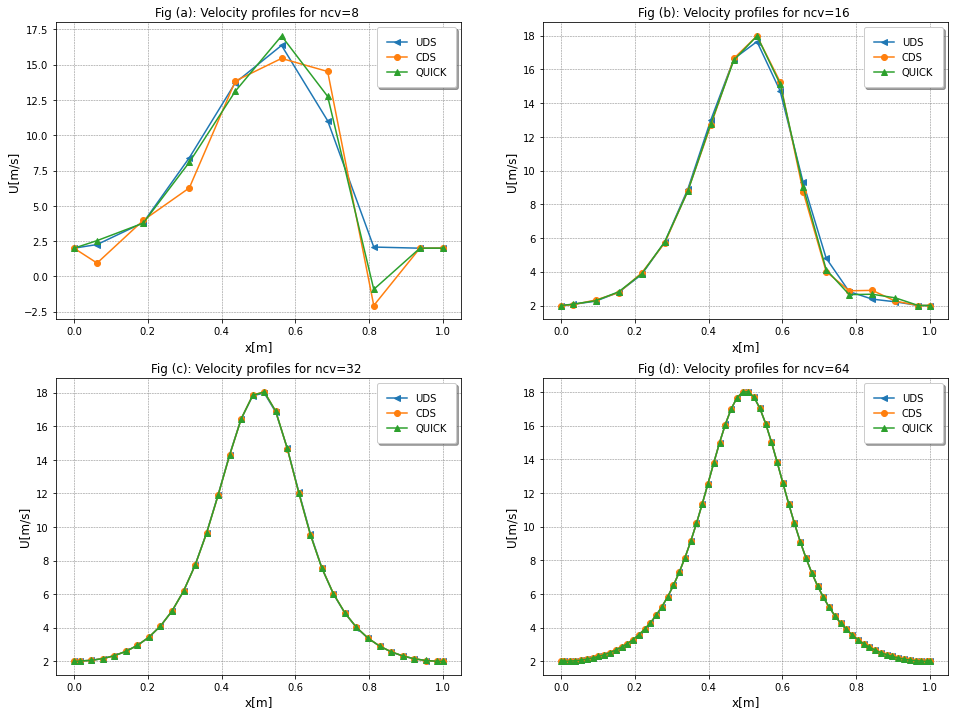

In [330]:
""" Velocity Plot for Comparison of 3 Schemes """
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(16,12))
axes1 = fig.add_subplot(2,2,3)
axes2 = fig.add_subplot(2,2,4)
axes3 = fig.add_subplot(2,2,1)
axes4 = fig.add_subplot(2,2,2)

axes1.plot(loc_uds_32, U_uds_32 , marker = "<", label = "UDS")
axes1.plot(loc_cds_32, U_cds_32 , marker = "o", label = "CDS")
axes1.plot(loc_quick_32, U_quick_32, marker = "^", label = "QUICK")
axes1.set_xlabel('x[m]',fontsize = 12)
axes1.set_ylabel('U[m/s]',fontsize = 12)
axes1.set_title('Fig (c): Velocity profiles for ncv=32 ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(loc_uds_64, U_uds_64 , marker = "<", label = "UDS")
axes2.plot(loc_cds_64, U_cds_64 , marker = "o", label = "CDS")
axes2.plot(loc_quick_64, U_quick_64, marker = "^", label = "QUICK")
axes2.set_xlabel('x[m]',fontsize = 12)
axes2.set_ylabel('U[m/s]',fontsize = 12)
axes2.set_title('Fig (d): Velocity profiles for ncv=64 ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(loc_uds_8, U_uds_8 , marker = "<", label = "UDS")
axes3.plot(loc_cds_8, U_cds_8 , marker = "o", label = "CDS")
axes3.plot(loc_quick_8, U_quick_8 , marker = "^", label = "QUICK")
axes3.set_xlabel('x[m]',fontsize = 12)
axes3.set_ylabel('U[m/s]',fontsize = 12)
axes3.set_title('Fig (a): Velocity profiles for ncv=8 ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(loc_uds_16, U_uds_16 , marker = "<", label = "UDS")
axes4.plot(loc_cds_16, U_cds_16 , marker = "o", label = "CDS")
axes4.plot(loc_quick_16, U_quick_16 , marker = "^", label = "QUICK")
axes4.set_xlabel('x[m]',fontsize = 12)
axes4.set_ylabel('U[m/s]',fontsize = 12)
axes4.set_title('Fig (b): Velocity profiles for ncv=16 ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

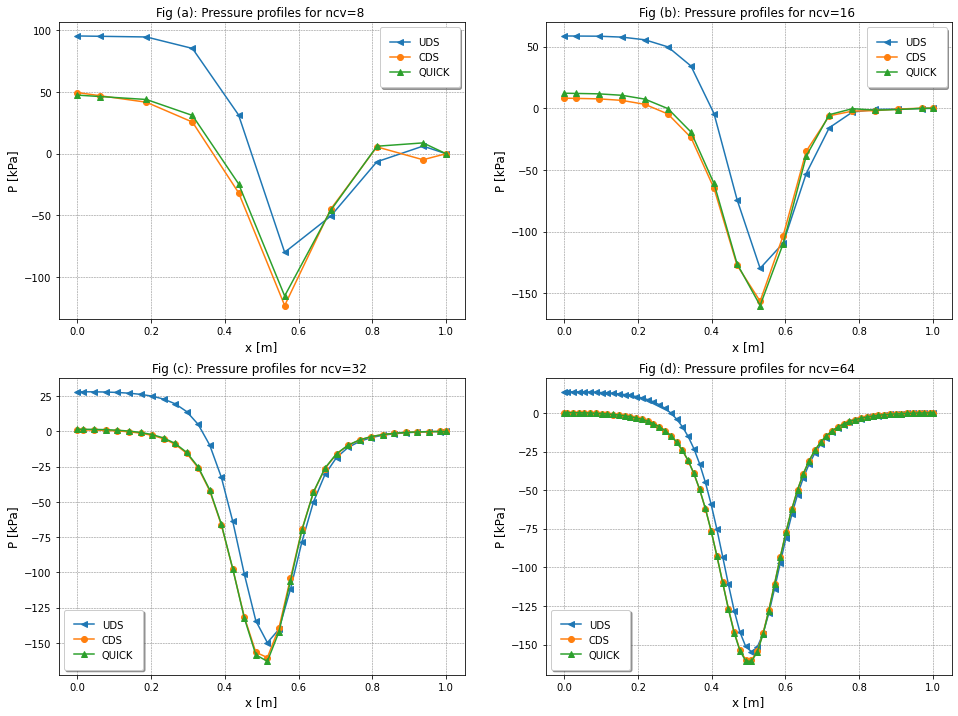

In [331]:
""" Pressure Plot for Comparison of 3 Schemes """
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(16,12))
axes1 = fig.add_subplot(2,2,3)
axes2 = fig.add_subplot(2,2,4)
axes3 = fig.add_subplot(2,2,1)
axes4 = fig.add_subplot(2,2,2)

axes1.plot(loc_uds_32, P_uds_32/1000 , marker = "<", label = "UDS")
axes1.plot(loc_cds_32, P_cds_32/1000 , marker = "o", label = "CDS")
axes1.plot(loc_quick_32, P_quick_32/1000, marker = "^", label = "QUICK")
axes1.set_xlabel('x [m]',fontsize = 12)
axes1.set_ylabel('P [kPa]',fontsize = 12)
axes1.set_title('Fig (c): Pressure profiles for ncv=32 ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(loc_uds_64, P_uds_64/1000 , marker = "<", label = "UDS")
axes2.plot(loc_cds_64, P_cds_64/1000 , marker = "o", label = "CDS")
axes2.plot(loc_quick_64, P_quick_64/1000, marker = "^", label = "QUICK")
axes2.set_xlabel('x [m]',fontsize = 12)
axes2.set_ylabel('P [kPa]',fontsize = 12)
axes2.set_title('Fig (d): Pressure profiles for ncv=64 ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(loc_uds_8, P_uds_8/1000 , marker = "<", label = "UDS")
axes3.plot(loc_cds_8, P_cds_8/1000 , marker = "o", label = "CDS")
axes3.plot(loc_quick_8, P_quick_8/1000 , marker = "^", label = "QUICK")
axes3.set_xlabel('x [m]',fontsize = 12)
axes3.set_ylabel('P [kPa]',fontsize = 12)
axes3.set_title('Fig (a): Pressure profiles for ncv=8 ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(loc_uds_16, P_uds_16/1000 , marker = "<", label = "UDS")
axes4.plot(loc_cds_16, P_cds_16/1000 , marker = "o", label = "CDS")
axes4.plot(loc_quick_16, P_quick_16/1000 , marker = "^", label = "QUICK")
axes4.set_xlabel('x [m]',fontsize = 12)
axes4.set_ylabel('P [kPa]',fontsize = 12)
axes4.set_title('Fig (b): Pressure profiles for ncv=16 ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

# Comments on the results

In [ ]:
# Solving the problem with UDS 

def UDS (ncv_def): 
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    Ht = 0.01
    lx = 1
    ncv = ncv_def
    grid = GridMe(lx, Ht, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e9
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 300
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    mu = 1e-3

    # Define the coefficients
    PU_coeffs = ScalarCoeffs(grid.ncv)
    PP_coeffs = ScalarCoeffs(grid.ncv)
    UP_coeffs = ScalarCoeffs(grid.ncv)
    UU_coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    U0 = 2
    P0 = 0

    # Initialize field variable arrays
    U = U0*np.ones(grid.ncv+2)
    P = P0*np.ones(grid.ncv+2)

    # Initialize advecting velocity and damping coefficient array
    dhat = np.zeros(grid.ncv+1)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions for velocity
    U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
    U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

    # Define boundary conditions for pressure
    P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
    P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    U_west_bc.apply()
    U_east_bc.apply()
    P_west_bc.apply()
    P_east_bc.apply()

    # Define the transient model
    Uold = np.copy(U)
    transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

    # Define the pressure force model
    pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

    # Define advecting velocity model
    advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

    # Define conservation of mass equation
    mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                    P_west_bc, P_east_bc, U_west_bc, U_east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" velocity field
        Uold[:] = U[:]

        # Iterate until the solution is converged
        for i in range(maxIter):

            # Zero all of the equations
            PP_coeffs.zero()
            PU_coeffs.zero()
            UU_coeffs.zero()
            UP_coeffs.zero()     

            # Assemble the momentum equations
            #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
            UU_coeffs = diffusion.add(UU_coeffs)
            UU_coeffs = advection.add(UU_coeffs)
            UU_coeffs = transient.add(UU_coeffs)
            UP_coeffs = pressure.add(UP_coeffs)

            # Assemble the mass equations
            advecting.update()
            PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

            # Compute residuals and check for convergence
            PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
            PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
            UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
            UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
            print("Iteration = {}.".format(i))
            print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
            print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
            if PmaxResid < converged and UmaxResid < converged:
                break

            # Solve the sparse matrix system
            dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)

            # Update the solutions 
            P[1:-1] += dP
            U[1:-1] += dU

            # Update boundary conditions
            U_west_bc.apply()
            U_east_bc.apply()
            P_west_bc.apply()
            P_east_bc.apply()

            # Update the advecting velocities
            advecting.update()

    U_uds = U
    P_uds = P
    loc_uds = grid.xP
    return (U_uds,P_uds,loc_uds)

print ('\033[1m' + 'Results for ncv = 8' '\033[0m'.center(100," "))
U_uds_8, P_uds_8, loc_uds_8 = UDS(8)
print ('\033[1m' + 'Results for ncv = 16' '\033[0m'.center(100," "))
U_uds_16, P_uds_16, loc_uds_16 = UDS(16)
print ('\033[1m' + 'Results for ncv = 32' '\033[0m'.center(100," "))
U_uds_32, P_uds_32, loc_uds_32 = UDS(32)
print ('\033[1m' + 'Results for ncv = 64 ' '\033[0m'.center(100," "))
U_uds_64, P_uds_64, loc_uds_64 = UDS(64)

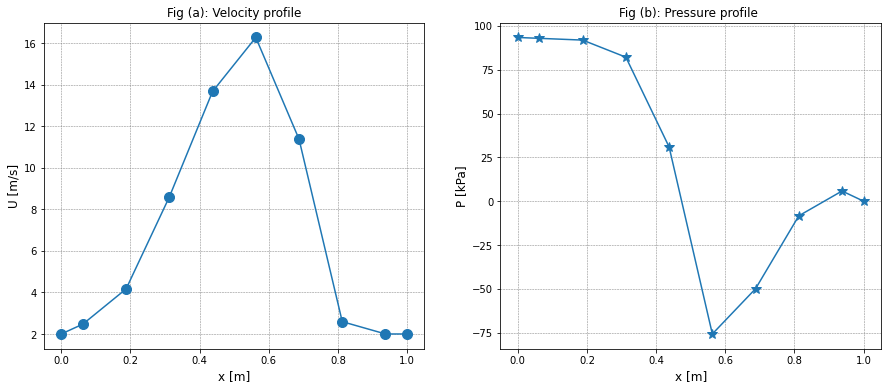

In [199]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(15,6))
axes1 = fig.add_subplot(1,2,1)
axes2 = fig.add_subplot(1,2,2)

axes1.plot(loc_uds_8, U_uds_8, marker = "o",markersize=10,)
axes1.set_xlabel('x [m]',fontsize = 12)
axes1.set_ylabel('U [m/s]',fontsize = 12)
axes1.set_title('Fig (a): Velocity profile',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

Pressure_kPa = P_uds_8/1000
axes2.plot(loc_uds_8, Pressure_kPa, marker = "*",markersize=10,)
axes2.set_xlabel('x [m]',fontsize = 12)
axes2.set_ylabel('P [kPa]',fontsize = 12)
axes2.set_title('Fig (b): Pressure profile ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

In [297]:
import numpy as np
import math

ncv = 8
lx = 1
Ht = 0.01


dx = lx/float(ncv)
print(dx)
xf = np.array([i*dx for i in range(ncv+1)])
print('xf=',xf)

xP = np.array([xf[0]] +[0.5*(xf[i]+xf[i+1]) for i in range(ncv)] +[xf[-1]])
print('xP=',xP)
        
        # Calculate the radius of the channel at face locations
rf = (2*Ht) + (Ht*np.cos((2*np.pi*xf)/lx))
print(rf)
        
        # Calculate the radius of the channel at cell centroid locations
rP = (2*Ht) + (Ht*np.cos((2*np.pi*xP)/lx))
print(rP)
        
        # Calculate face areas
Af = np.pi * ((rf)**2)
print('Af=',Af)

        # Calculate the outer surface area for each cell
Ao = (2*np.pi*rP[1:-1])*dx
print('Ao=',Ao)

        # Calculate cell volumesxf
vol = np.pi*(rP[1:-1]**2)*dx
print('vol=',vol)

0.125
xf= [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
xP= [0.     0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.    ]
[0.03       0.02707107 0.02       0.01292893 0.01       0.01292893
 0.02       0.02707107 0.03      ]
[0.03       0.0292388  0.02382683 0.01617317 0.0107612  0.0107612
 0.01617317 0.02382683 0.0292388  0.03      ]
Af= [0.00282743 0.00230229 0.00125664 0.00052514 0.00031416 0.00052514
 0.00125664 0.00230229 0.00282743]
Ao= [0.0229641  0.01871355 0.01270237 0.00845183 0.00845183 0.01270237
 0.01871355 0.0229641 ]
vol= [3.35721254e-04 2.22942351e-04 1.02718805e-04 4.54759383e-05
 4.54759383e-05 1.02718805e-04 2.22942351e-04 3.35721254e-04]
